# BERT-Tiny Self-Attention Layer
- Reproduce the self-attention layer to obtain intermediate features.  
- Use INTEL FP8 emulator for quantization.  

References:
1. https://github.com/IntelLabs/FP8-Emulation-Toolkit.git
2. https://huggingface.co/learn/nlp-course/en/chapter6/3b?fw=pt  
3. https://github.com/huggingface/transformers/blob/main/src/transformers/models/bert/modeling_bert.py

# Libraries

In [27]:
import math
import random
import numpy as np
from tqdm import tqdm
import copy
import pandas as pd
import matplotlib.pyplot as plt

import torch
from torch import nn
from typing import List, Optional, Tuple, Union

# INTEL emulator
from mpemu import mpt_emu

import collections
import transformers
from transformers import AutoTokenizer, AutoModelForQuestionAnswering
from transformers import TrainingArguments, Trainer
from transformers import default_data_collator

from datasets import load_dataset, load_metric

In [2]:
# Set CPU or GPU
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
# device = torch.device("cpu")
print(f'Running on {device}')

Running on cuda


# Classes
From `pytorch_transformers.modeling_bert`:
- BertEmbeddings() --> to get input encodings.
- BertSelfAttention() --> to get Q-vectors, K-vectors, and score matrices.

- Embedding Layer.

In [3]:
# Reproduce the Embedding Layer for BERT-Tiny
class BertEmbeddings(nn.Module):
    """Construct the embeddings from word, position and token_type embeddings."""

    def __init__(self):
        super().__init__()

        # Parameters from BERT-Tiny
        self.vocab_size = 30522
        self.hidden_size = 128
        self.pad_token_id = 0
        self.max_position_embeddings = 512
        self.type_vocab_size = 2
        self.layer_norm_eps = 1e-12
        self.hidden_dropout_prob = 0.1

        self.word_embeddings = nn.Embedding(self.vocab_size, self.hidden_size, padding_idx=self.pad_token_id)
        self.position_embeddings = nn.Embedding(self.max_position_embeddings, self.hidden_size)
        self.token_type_embeddings = nn.Embedding(self.type_vocab_size, self.hidden_size)

        # self.LayerNorm is not snake-cased to stick with TensorFlow model variable name and be able to load
        # any TensorFlow checkpoint file
        self.LayerNorm = nn.LayerNorm(self.hidden_size, eps=self.layer_norm_eps)
        self.dropout = nn.Dropout(self.hidden_dropout_prob)
        # position_ids (1, len position emb) is contiguous in memory and exported when serialized
        # In the config.json, there is no attribute --> use the default
        # self.position_embedding_type = getattr(config, "position_embedding_type", "absolute")
        self.position_embedding_type = "absolute"
        self.register_buffer(
            "position_ids", torch.arange(self.max_position_embeddings).expand((1, -1)), persistent=False
        )
        self.register_buffer(
            "token_type_ids", torch.zeros(self.position_ids.size(), dtype=torch.long), persistent=False
        )

    def forward(
        self,
        input_ids: Optional[torch.LongTensor] = None,
        token_type_ids: Optional[torch.LongTensor] = None,
        position_ids: Optional[torch.LongTensor] = None,
        inputs_embeds: Optional[torch.FloatTensor] = None,
        past_key_values_length: int = 0,
    ) -> torch.Tensor:
        if input_ids is not None:
            input_shape = input_ids.size()
        else:
            input_shape = inputs_embeds.size()[:-1]

        seq_length = input_shape[1]

        if position_ids is None:
            position_ids = self.position_ids[:, past_key_values_length : seq_length + past_key_values_length]

        # Setting the token_type_ids to the registered buffer in constructor where it is all zeros, which usually occurs
        # when its auto-generated, registered buffer helps users when tracing the model without passing token_type_ids, solves
        # issue #5664
        if token_type_ids is None:
            if hasattr(self, "token_type_ids"):
                buffered_token_type_ids = self.token_type_ids[:, :seq_length]
                buffered_token_type_ids_expanded = buffered_token_type_ids.expand(input_shape[0], seq_length)
                token_type_ids = buffered_token_type_ids_expanded
            else:
                token_type_ids = torch.zeros(input_shape, dtype=torch.long, device=self.position_ids.device)

        if inputs_embeds is None:
            inputs_embeds = self.word_embeddings(input_ids)
        token_type_embeddings = self.token_type_embeddings(token_type_ids)

        embeddings = inputs_embeds + token_type_embeddings
        if self.position_embedding_type == "absolute":
            position_embeddings = self.position_embeddings(position_ids)
            embeddings += position_embeddings
        embeddings = self.LayerNorm(embeddings)
        embeddings = self.dropout(embeddings)
        return embeddings

- Self-Attention Layer.

In [4]:
# Custom Self-Attention Layer based on the original design from Hugging Face
class BertSelfAttention(nn.Module):
    def __init__(self):
        super().__init__()
        
        # Parameters from BERT-Tiny
        self.hidden_size = 128
        self.num_attention_heads = 2
        self.attention_probs_dropout_prob = 0.1
        
        # Verify the input dimensions
        if self.hidden_size % self.num_attention_heads != 0:
            raise ValueError(
                f"The hidden size ({self.hidden_size}) is not a multiple of the number of attention "
                f"heads ({self.num_attention_heads})"
            )

        
        # Calculate internal parameters
        self.attention_head_size = int(self.hidden_size / self.num_attention_heads)
        self.all_head_size = self.num_attention_heads * self.attention_head_size

        # Model Layers
        self.query = nn.Linear(self.hidden_size, self.all_head_size)
        self.key = nn.Linear(self.hidden_size, self.all_head_size)
        self.value = nn.Linear(self.hidden_size, self.all_head_size)

        self.dropout = nn.Dropout(self.attention_probs_dropout_prob)
        
        # In general, the absolute option is used --> Check positional encoding
        # https://jaketae.github.io/study/relative-positional-encoding/
        self.position_embedding_type = "absolute"
        
    # -> the symbol is used to indicate the type that function returns
    # This function separates the Q, K, or V vectors for each head attention
    def transpose_for_scores(self, x: torch.Tensor) -> torch.Tensor:
        new_x_shape = x.size()[:-1] + (self.num_attention_heads, self.attention_head_size)
        x = x.view(new_x_shape)
        # Change dimension: (batch_size, num_attention_heads, n_sample, vector_size)
        return x.permute(0, 2, 1, 3)

    def forward(
        self,
        hidden_states: torch.Tensor,
        attention_mask: Optional[torch.FloatTensor] = None,
        head_mask: Optional[torch.FloatTensor] = None,
        encoder_hidden_states: Optional[torch.FloatTensor] = None,
        encoder_attention_mask: Optional[torch.FloatTensor] = None,
        past_key_value: Optional[Tuple[Tuple[torch.FloatTensor]]] = None,
        output_attentions: Optional[bool] = False,
    ) -> Tuple[torch.Tensor]:

        # Calculate Q-vectors and separate in corresponding heads
        mixed_query_layer = self.query(hidden_states)
        query_layer = self.transpose_for_scores(mixed_query_layer)

        # Calculate K-vector and separate in corresponding heads      
        key_layer = self.transpose_for_scores(self.key(hidden_states))
        # Calculate K-vector and separate in corresponding heads
        value_layer = self.transpose_for_scores(self.value(hidden_states))

        # Take the dot product between "query" and "key" to get the raw attention scores.
        # K-vector is transpose in the last two dimensions to get a column vector
        raw_scores = torch.matmul(query_layer, key_layer.transpose(-1, -2))

        # Attention scores --> to ensures that the Euclidean length of the weight vectors will be approximately in the same magnitude
        attention_scores = raw_scores / math.sqrt(self.attention_head_size)
        
        # if attention_mask is not None:
        #     # Apply the attention mask is (precomputed for all layers in BertModel forward() function)
        #     attention_scores = attention_scores + attention_mask

        # Normalize the attention scores to probabilities.
        # Last dimension is used because the probabilities comes from
        # calculating one Q-vector with all K-vectors.
        attention_probs = nn.functional.softmax(attention_scores, dim=-1)
        
        ##################################################################################################
        # # This is actually dropping out entire tokens to attend to, which might
        # # seem a bit unusual, but is taken from the original Transformer paper.
        # attention_probs = self.dropout(attention_probs)

        # # Mask heads if we want to
        # if head_mask is not None:
        #     attention_probs = attention_probs * head_mask

        # context_layer = torch.matmul(attention_probs, value_layer)

        # context_layer = context_layer.permute(0, 2, 1, 3).contiguous()
        # new_context_layer_shape = context_layer.size()[:-2] + (self.all_head_size,)
        # context_layer = context_layer.view(new_context_layer_shape)

        # outputs = (context_layer, attention_probs) if output_attentions else (context_layer,)

        # return outputs
        ###################################################################################################

        # Return Q, K, and V vectors --> separated on head attentions
        # Scores: Raw, Attention (scaled), Probabilities (softmax)
        return query_layer, key_layer, value_layer, raw_scores, attention_scores, attention_probs


# Functions

In [5]:
'''
Pre-process the validation dataset for testing

IN:
examples <-- text samples (validation dataset)
tokenizer <-- corresponding tokenizer
pad_on_right <-- question + context format
max_length <-- max. length of feature
doc_stride <-- overlap for split context

OUT:
tokenized_examples --> model inputs
'''
def prepare_validation_features(examples):
    # Some of the questions have lots of whitespace on the left, which is not useful and will make the
    # truncation of the context fail (the tokenized question will take a lots of space). So we remove that
    # left whitespace
    examples["question"] = [q.lstrip() for q in examples["question"]]

    # Tokenize our examples with truncation and maybe padding, but keep the overflows using a stride. This results
    # in one example possible giving several features when a context is long, each of those features having a
    # context that overlaps a bit the context of the previous feature.
    tokenized_examples = tokenizer(
        examples["question" if pad_on_right else "context"],
        examples["context" if pad_on_right else "question"],
        truncation="only_second" if pad_on_right else "only_first",
        max_length=max_length,
        stride=doc_stride,
        return_overflowing_tokens=True,
        return_offsets_mapping=True,
        padding="max_length",
    )

    # Since one example might give us several features if it has a long context, we need a map from a feature to
    # its corresponding example. This key gives us just that.
    sample_mapping = tokenized_examples.pop("overflow_to_sample_mapping")

    # We keep the example_id that gave us this feature and we will store the offset mappings.
    tokenized_examples["example_id"] = []

    for i in range(len(tokenized_examples["input_ids"])):
        # Grab the sequence corresponding to that example (to know what is the context and what is the question).
        sequence_ids = tokenized_examples.sequence_ids(i)
        context_index = 1 if pad_on_right else 0

        # One example can give several spans, this is the index of the example containing this span of text.
        sample_index = sample_mapping[i]
        tokenized_examples["example_id"].append(examples["id"][sample_index])

        # Set to None the offset_mapping that are not part of the context so it's easy to determine if a token
        # position is part of the context or not.
        tokenized_examples["offset_mapping"][i] = [
            (o if sequence_ids[k] == context_index else None)
            for k, o in enumerate(tokenized_examples["offset_mapping"][i])
        ]

    return tokenized_examples

# Input Features

## 1. Model Parameters

In [6]:
# Differenciate between SQUAD v1 or 2
squad_v2 = True

# INTEL Example
# model_checkpoint = "google-bert/bert-large-uncased-whole-word-masking-finetuned-squad"
# batch_size = 24

# Model Definition
model_checkpoint = "mrm8488/bert-tiny-finetuned-squadv2"
# Reduce bacth size to get enough data for analysis
# batch_size = 24
batch_size = 12

In [7]:
# Pre-processing definitions
# Same in the INTEL example

# The maximum length of a feature (question and context)
max_length = 384 
# The authorized overlap between two part of the context when splitting is needed.
doc_stride = 128 

In [8]:
# Get the corresponding tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)
print(tokenizer)

BertTokenizerFast(name_or_path='mrm8488/bert-tiny-finetuned-squadv2', vocab_size=30522, model_max_length=1000000000000000019884624838656, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}, clean_up_tokenization_spaces=True),  added_tokens_decoder={
	0: AddedToken("[PAD]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	100: AddedToken("[UNK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	101: AddedToken("[CLS]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	102: AddedToken("[SEP]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	103: AddedToken("[MASK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
}


In [9]:
# BERT-tiny model
model = AutoModelForQuestionAnswering.from_pretrained(model_checkpoint)
print(model)

Some weights of the model checkpoint at mrm8488/bert-tiny-finetuned-squadv2 were not used when initializing BertForQuestionAnswering: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
- This IS expected if you are initializing BertForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


BertForQuestionAnswering(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 128, padding_idx=0)
      (position_embeddings): Embedding(512, 128)
      (token_type_embeddings): Embedding(2, 128)
      (LayerNorm): LayerNorm((128,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-1): 2 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=128, out_features=128, bias=True)
              (key): Linear(in_features=128, out_features=128, bias=True)
              (value): Linear(in_features=128, out_features=128, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=128, out_features=128, bias=True)
              (LayerNorm): LayerNorm((128,), eps=1e-12, elemen

## 2. Dataset

In [9]:
# Load the corresponding dataset
datasets = load_dataset("squad_v2" if squad_v2 else "squad")

In [10]:
print(datasets)
print(f'Train Sample: \n {datasets["train"][0]} \n')
print(f'Test Sample: \n {datasets["validation"][0]} \n')

DatasetDict({
    train: Dataset({
        features: ['id', 'title', 'context', 'question', 'answers'],
        num_rows: 130319
    })
    validation: Dataset({
        features: ['id', 'title', 'context', 'question', 'answers'],
        num_rows: 11873
    })
})
Train Sample: 
 {'id': '56be85543aeaaa14008c9063', 'title': 'Beyoncé', 'context': 'Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ bee-YON-say) (born September 4, 1981) is an American singer, songwriter, record producer and actress. Born and raised in Houston, Texas, she performed in various singing and dancing competitions as a child, and rose to fame in the late 1990s as lead singer of R&B girl-group Destiny\'s Child. Managed by her father, Mathew Knowles, the group became one of the world\'s best-selling girl groups of all time. Their hiatus saw the release of Beyoncé\'s debut album, Dangerously in Love (2003), which established her as a solo artist worldwide, earned five Grammy Awards and featured the Billboard Hot 100 numbe

## 3. Example
- Find a short sample in the validation dataset.
- Pre-process the example --> get the input features

In [11]:
# Size of example
len_low = 65
len_up = 70

In [12]:
# Find the example
for i, example in enumerate(datasets["validation"]):
    len_f = len(tokenizer(example["question"], example["context"])["input_ids"]) 
    if len_f > len_low and len_f < len_up:
        print(f'Found an example with length {len_f}.')
        break
example = datasets["validation"][i]
print(f'Sample number {i}: \n {example}')

Found an example with length 69.
Sample number 78: 
 {'id': '56de1563cffd8e1900b4b5c4', 'title': 'Normans', 'context': 'The further decline of Byzantine state-of-affairs paved the road to a third attack in 1185, when a large Norman army invaded Dyrrachium, owing to the betrayal of high Byzantine officials. Some time later, Dyrrachium—one of the most important naval bases of the Adriatic—fell again to Byzantine hands.', 'question': 'Where was Dyrrachium located?', 'answers': {'text': ['the Adriatic', 'the Adriatic', 'Adriatic'], 'answer_start': [257, 257, 261]}}


In [13]:
# Extract question and context for inference
question = example['question']
print(f'Extracted Question: \n{question} \n')

context = example['context']
print(f'Extracted Context: \n{context} \n')

Extracted Question: 
Where was Dyrrachium located? 

Extracted Context: 
The further decline of Byzantine state-of-affairs paved the road to a third attack in 1185, when a large Norman army invaded Dyrrachium, owing to the betrayal of high Byzantine officials. Some time later, Dyrrachium—one of the most important naval bases of the Adriatic—fell again to Byzantine hands. 



In [14]:
inputs = tokenizer(question, context, return_tensors="pt")
print(f'Input Features: {inputs["input_ids"].shape}: \n {inputs} \n')

# Tokens [UNK] shows the words that are not part of the vocabulary.
print('Decoded Input Features:')
for x in inputs["input_ids"]:
    print(tokenizer.decode(x))

Input Features: torch.Size([1, 69]): 
 {'input_ids': tensor([[  101,   100,  2001,   100,  2284,  1029,   102,   100,  2582,  6689,
          1997,   100,  2110,  1011,  1997,  1011,  3821, 12308,  1996,  2346,
          2000,  1037,  2353,  2886,  1999, 12963,  2629,  1010,  2043,  1037,
          2312,   100,  2390, 10836,   100,  1010, 11427,  2000,  1996, 14583,
          1997,  2152,   100,  4584,  1012,   100,  2051,  2101,  1010,   100,
          1517,  2028,  1997,  1996,  2087,  2590,  3987,  7888,  1997,  1996,
           100,  1517,  3062,  2153,  2000,   100,  2398,  1012,   102]]), 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

In [15]:
# For the embedding layer --> only the ids
input_features = inputs["input_ids"]

# Send to device (tensor)
input_features = input_features.to(device)

print(input_features)
print(input_features.shape)
print(input_features.dtype)

tensor([[  101,   100,  2001,   100,  2284,  1029,   102,   100,  2582,  6689,
          1997,   100,  2110,  1011,  1997,  1011,  3821, 12308,  1996,  2346,
          2000,  1037,  2353,  2886,  1999, 12963,  2629,  1010,  2043,  1037,
          2312,   100,  2390, 10836,   100,  1010, 11427,  2000,  1996, 14583,
          1997,  2152,   100,  4584,  1012,   100,  2051,  2101,  1010,   100,
          1517,  2028,  1997,  1996,  2087,  2590,  3987,  7888,  1997,  1996,
           100,  1517,  3062,  2153,  2000,   100,  2398,  1012,   102]],
       device='cuda:0')
torch.Size([1, 69])
torch.int64


## 4. Validation Dataset
- To determine the distribution inside the self-attention layer.
- Take 24 random samples, each one with 384 tokens.
    - Produce around 1M data points for vectors Q, K, and V.
    - Produce around 7M data points for scores.

In [16]:
# Format question + context
pad_on_right = tokenizer.padding_side == "right"

inputs_val = datasets["validation"].map(
    prepare_validation_features,
    batched=True,
    remove_columns=datasets["validation"].column_names
)
print(inputs_val)

Dataset({
    features: ['input_ids', 'token_type_ids', 'attention_mask', 'offset_mapping', 'example_id'],
    num_rows: 12106
})


In [37]:
# Prepare 24 random samples
n_sample = 24
input_features_val = []

for i in range(n_sample):
    # Choose a random sample from validation dataset
    input_features_val.append(random.choice(inputs_val["input_ids"]))

# Debug
print(input_features_val[0])
print(len(input_features_val))
print(type(input_features_val))

[101, 100, 2003, 1996, 3399, 1997, 6622, 2241, 2006, 1029, 102, 100, 6958, 1997, 15018, 2140, 8338, 2003, 2241, 2006, 1996, 3311, 1997, 11954, 1999, 25503, 5749, 1012, 100, 11767, 4839, 2012, 1996, 2168, 2051, 2558, 2802, 1996, 2088, 1010, 2037, 3739, 2030, 1006, 2823, 1007, 6438, 2089, 2022, 2109, 2000, 3073, 1037, 5816, 2287, 1997, 1996, 13197, 1999, 2029, 2027, 2024, 2179, 1012, 100, 2006, 6481, 4201, 2041, 2011, 100, 100, 2471, 1037, 3634, 2086, 2077, 1996, 4772, 1997, 100, 100, 1005, 1055, 3399, 1997, 6622, 1010, 1996, 6481, 1997, 8338, 2020, 2764, 9174, 1997, 12761, 2245, 1012, 100, 6958, 4150, 3243, 3375, 1010, 2174, 1010, 2445, 1996, 9662, 7368, 1997, 10725, 3989, 1010, 1996, 2334, 3989, 1997, 10725, 4127, 2349, 2000, 11457, 3431, 1999, 6552, 1006, 6904, 9243, 2689, 1999, 25503, 22913, 1007, 1010, 1998, 2008, 2025, 2035, 11954, 2089, 2022, 2179, 16452, 2012, 1996, 2168, 2051, 1012, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [38]:
# For the embedding layer --> only the ids
# The results is a list and need to become a tensor
input_features_val = torch.Tensor(input_features_val).type(torch.int64)

# Arrange the input features in batches run inference --> avoid crashing the kernel or GPU
# Dropping some elements at the end
input_features_val = torch.reshape(input_features_val, (-1,batch_size,max_length))

# Send to device
input_features_val = input_features_val.to(device)

print(input_features_val)
print(input_features_val.shape)
print(input_features_val.dtype)

tensor([[[  101,   100,  2003,  ...,     0,     0,     0],
         [  101,   100,  2003,  ...,     0,     0,     0],
         [  101,   100,  4490,  ...,     0,     0,     0],
         ...,
         [  101,   100, 19470,  ...,     0,     0,     0],
         [  101,   100,  2312,  ...,     0,     0,     0],
         [  101,   100,  2116,  ...,     0,     0,     0]],

        [[  101,   100,  2515,  ...,     0,     0,     0],
         [  101,   100,  2095,  ...,     0,     0,     0],
         [  101,   100,  3596,  ...,     0,     0,     0],
         ...,
         [  101,   100, 14788,  ...,     0,     0,     0],
         [  101,   100,  2003,  ...,     0,     0,     0],
         [  101,   100,  2116,  ...,     0,     0,     0]]], device='cuda:0')
torch.Size([2, 12, 384])
torch.int64


# Input Embeddings
- Load the correspoding weights from BERT-tiny.

In [39]:
# Instantiate BERT-tiny Embedding Layer
btiny_embed_layer = BertEmbeddings()
print(btiny_embed_layer)

BertEmbeddings(
  (word_embeddings): Embedding(30522, 128, padding_idx=0)
  (position_embeddings): Embedding(512, 128)
  (token_type_embeddings): Embedding(2, 128)
  (LayerNorm): LayerNorm((128,), eps=1e-12, elementwise_affine=True)
  (dropout): Dropout(p=0.1, inplace=False)
)


- Load weigths for Word Embeddings Layer.

In [24]:
# Read from stored file
df = pd.read_csv('./matrices_BERTtiny/w_emb_weight_embedding.csv', header=None)
display(df)

# Dataframe to Tensor
w_embedding = torch.Tensor(df.values)

# Make sure shape correspond to the target network
w_embedding = torch.reshape(w_embedding, btiny_embed_layer.word_embeddings.weight.shape)


print(w_embedding)
print(w_embedding.shape)
print(w_embedding.dtype)

# Load the custom weights to the model
btiny_embed_layer.word_embeddings.weight = torch.nn.Parameter(w_embedding)

,0,1,2,3,4,5,6,7,8,9,...,118,119,120,121,122,123,124,125,126,127
0,-0.004102,-0.030695,-0.003530,-0.411438,-0.014942,0.005746,0.023953,0.000162,0.026952,0.026791,...,0.009847,0.051232,0.009227,-0.011709,0.008851,-0.014839,-0.167650,0.018925,0.003740,-0.002923
1,-0.000427,-0.036929,-0.017168,-0.423627,0.010980,0.010359,0.034110,-0.019472,0.055122,0.031442,...,0.050806,0.036249,-0.011282,0.014735,0.018930,-0.042994,-0.151992,0.029314,-0.010398,0.026772
2,0.005942,0.004212,-0.019566,-0.385447,0.013480,0.034551,0.014485,0.002080,0.056799,0.033259,...,0.013886,0.032323,-0.003076,0.017598,0.012769,-0.045568,-0.178516,0.016799,-0.027802,-0.006902
3,0.000417,-0.050860,-0.016444,-0.558925,0.003685,0.037643,0.029225,-0.021511,0.032243,0.031892,...,0.052648,0.030534,0.006766,0.005378,0.029141,-0.026603,-0.123795,0.028228,-0.020112,0.008221
4,0.010791,0.001671,0.013703,-0.512898,0.007565,0.019733,0.040316,-0.006930,0.044723,0.036560,...,0.036957,0.033785,0.007198,-0.015781,0.028073,-0.004094,-0.178751,0.011329,-0.032976,0.037174
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30517,0.008556,-0.013608,0.016184,-0.466869,0.004890,0.019206,0.024662,-0.006580,0.021015,0.021744,...,0.032921,0.040517,0.016282,-0.006558,0.038389,0.004930,-0.154879,0.026375,0.004540,0.013948
30518,-0.004366,-0.028112,-0.012219,-0.485433,-0.017654,0.011989,0.013574,0.007398,0.041075,0.037646,...,0.022182,0.057581,0.008038,0.006264,0.002978,-0.018174,-0.138781,0.006097,-0.000765,-0.002499
30519,0.035573,-0.015891,0.004995,-0.441475,0.024180,-0.004004,0.007571,-0.018132,0.043679,0.041178,...,0.019628,0.015768,-0.005383,0.016564,0.052644,-0.016092,-0.154145,0.005407,-0.011270,-0.000070
30520,-0.008702,-0.022516,0.003199,-0.396877,0.022990,0.017911,0.018286,0.004663,0.031892,0.025294,...,0.018768,0.017948,-0.003442,0.007416,0.019297,-0.000321,-0.187129,0.027591,-0.019554,0.002402


tensor([[-4.1018e-03, -3.0695e-02, -3.5295e-03,  ...,  1.8925e-02,
          3.7396e-03, -2.9233e-03],
        [-4.2748e-04, -3.6929e-02, -1.7168e-02,  ...,  2.9314e-02,
         -1.0398e-02,  2.6772e-02],
        [ 5.9418e-03,  4.2119e-03, -1.9566e-02,  ...,  1.6799e-02,
         -2.7802e-02, -6.9017e-03],
        ...,
        [ 3.5573e-02, -1.5891e-02,  4.9951e-03,  ...,  5.4071e-03,
         -1.1270e-02, -6.9528e-05],
        [-8.7018e-03, -2.2516e-02,  3.1993e-03,  ...,  2.7591e-02,
         -1.9554e-02,  2.4023e-03],
        [-7.8904e-02, -7.5407e-02, -4.6660e-03,  ..., -5.3340e-03,
         -4.4993e-02,  5.9842e-02]])
torch.Size([30522, 128])
torch.float32


In [25]:
# Verify
print('\n\nModel with loaded params:')
for name, param in btiny_embed_layer.word_embeddings.named_parameters():
    print(name)
    print(param)
    print(param.dtype)



Model with loaded params:
weight
Parameter containing:
tensor([[-4.1018e-03, -3.0695e-02, -3.5295e-03,  ...,  1.8925e-02,
          3.7396e-03, -2.9233e-03],
        [-4.2748e-04, -3.6929e-02, -1.7168e-02,  ...,  2.9314e-02,
         -1.0398e-02,  2.6772e-02],
        [ 5.9418e-03,  4.2119e-03, -1.9566e-02,  ...,  1.6799e-02,
         -2.7802e-02, -6.9017e-03],
        ...,
        [ 3.5573e-02, -1.5891e-02,  4.9951e-03,  ...,  5.4071e-03,
         -1.1270e-02, -6.9528e-05],
        [-8.7018e-03, -2.2516e-02,  3.1993e-03,  ...,  2.7591e-02,
         -1.9554e-02,  2.4023e-03],
        [-7.8904e-02, -7.5407e-02, -4.6660e-03,  ..., -5.3340e-03,
         -4.4993e-02,  5.9842e-02]], requires_grad=True)
torch.float32


- Load weigths for Position Embeddings Layer.

In [26]:
# Read from stored file
df = pd.read_csv('./matrices_BERTtiny/p_emb_weight_embedding.csv', header=None)
display(df)

# Dataframe to Tensor
w_embedding = torch.Tensor(df.values)

# Make sure shape correspond to the target network
w_embedding = torch.reshape(w_embedding, btiny_embed_layer.position_embeddings.weight.shape)


print(w_embedding)
print(w_embedding.shape)
print(w_embedding.dtype)

# Load the custom weights to the model
btiny_embed_layer.position_embeddings.weight = torch.nn.Parameter(w_embedding)

,0,1,2,3,4,5,6,7,8,9,...,118,119,120,121,122,123,124,125,126,127
0,0.048799,-0.021985,-0.512618,-0.007519,0.004999,-0.001290,-0.013943,0.019414,0.049354,-0.005497,...,0.000633,0.004712,-0.002644,-0.046888,-0.019192,0.086546,-0.073178,0.080832,-0.009050,0.012282
1,-0.035620,0.008837,-0.036291,-0.025621,-0.036160,0.008466,-0.004186,0.002189,0.018750,-0.039869,...,0.022351,0.008900,-0.016530,0.001127,-0.035351,-0.068163,-0.060463,-0.052477,-0.009874,-0.051069
2,-0.052387,-0.007274,-0.025076,-0.008414,-0.033572,0.003951,0.004875,0.001596,0.032732,-0.040867,...,0.017271,-0.002181,0.000754,-0.000436,-0.021568,-0.059764,-0.045783,-0.041533,0.027022,-0.009572
3,-0.035884,-0.006201,-0.015133,-0.005845,-0.022721,0.030334,0.029940,0.014519,0.025118,-0.033847,...,-0.002718,0.006820,-0.002802,-0.018078,0.014845,-0.034942,-0.044802,-0.037966,0.031754,0.007609
4,-0.036029,0.007621,-0.013844,0.007194,-0.003605,0.027647,0.023641,0.008893,0.002001,-0.039015,...,-0.021709,0.015600,-0.011703,-0.006383,0.030896,-0.014286,-0.070968,-0.045872,0.014375,0.013205
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
507,-0.019778,-0.025677,0.057292,-0.013457,-0.042316,-0.045250,-0.004120,0.000235,-0.025485,-0.009929,...,0.021269,-0.025991,0.004758,-0.018824,-0.025798,-0.037680,-0.032863,-0.057193,0.012679,-0.026734
508,-0.031045,-0.021198,0.048681,-0.019791,-0.032540,-0.022947,0.013226,0.016184,-0.031092,-0.015421,...,0.016641,-0.011229,0.013116,-0.031141,0.004250,-0.013063,-0.049673,-0.068013,0.028564,-0.027271
509,-0.027013,0.007404,0.029932,-0.011022,-0.018286,-0.004139,0.023392,0.025712,-0.047099,-0.001434,...,0.008016,0.007969,0.015612,-0.017325,0.032569,0.021893,-0.061052,-0.065008,0.022377,-0.034998
510,-0.034684,0.028806,-0.037017,0.030278,-0.031173,0.004782,0.031265,0.028934,-0.062641,-0.019988,...,0.016922,0.000335,0.009324,-0.017013,0.009492,0.050202,-0.165319,-0.011996,-0.021707,-0.100012


tensor([[ 0.0488, -0.0220, -0.5126,  ...,  0.0808, -0.0090,  0.0123],
        [-0.0356,  0.0088, -0.0363,  ..., -0.0525, -0.0099, -0.0511],
        [-0.0524, -0.0073, -0.0251,  ..., -0.0415,  0.0270, -0.0096],
        ...,
        [-0.0270,  0.0074,  0.0299,  ..., -0.0650,  0.0224, -0.0350],
        [-0.0347,  0.0288, -0.0370,  ..., -0.0120, -0.0217, -0.1000],
        [ 0.0834, -0.0866, -0.4170,  ...,  0.0410,  0.0132,  0.0484]])
torch.Size([512, 128])
torch.float32


In [27]:
# Verify
print('\n\nModel with loaded params:')
for name, param in btiny_embed_layer.position_embeddings.named_parameters():
    print(name)
    print(param)
    print(param.dtype)



Model with loaded params:
weight
Parameter containing:
tensor([[ 0.0488, -0.0220, -0.5126,  ...,  0.0808, -0.0090,  0.0123],
        [-0.0356,  0.0088, -0.0363,  ..., -0.0525, -0.0099, -0.0511],
        [-0.0524, -0.0073, -0.0251,  ..., -0.0415,  0.0270, -0.0096],
        ...,
        [-0.0270,  0.0074,  0.0299,  ..., -0.0650,  0.0224, -0.0350],
        [-0.0347,  0.0288, -0.0370,  ..., -0.0120, -0.0217, -0.1000],
        [ 0.0834, -0.0866, -0.4170,  ...,  0.0410,  0.0132,  0.0484]],
       requires_grad=True)
torch.float32


- Load weigths for Token Type Embeddings Layer.

In [28]:
# Read from stored file
df = pd.read_csv('./matrices_BERTtiny/tt_emb_weight_embedding.csv', header=None)
display(df)

# Dataframe to Tensor
w_embedding = torch.Tensor(df.values)

# Make sure shape correspond to the target network
w_embedding = torch.reshape(w_embedding, btiny_embed_layer.token_type_embeddings.weight.shape)


print(w_embedding)
print(w_embedding.shape)
print(w_embedding.dtype)

# Load the custom weights to the model
btiny_embed_layer.token_type_embeddings.weight = torch.nn.Parameter(w_embedding)

,0,1,2,3,4,5,6,7,8,9,...,118,119,120,121,122,123,124,125,126,127
0,-0.012067,0.015102,0.006183,0.030114,0.020067,-0.028070,-0.007965,-0.00288,-0.025338,-0.025838,...,-0.003862,-0.002961,-0.011757,0.000038,-0.001596,-0.001333,-0.140390,0.002437,-0.005593,-0.002244
1,-0.004326,-0.007665,-0.005287,0.015861,0.004550,-0.008242,-0.006929,-0.00242,-0.016895,-0.000231,...,-0.011166,-0.005412,-0.002127,0.004642,0.002264,0.003555,-0.162524,-0.019640,0.001231,0.014885


tensor([[-1.2067e-02,  1.5102e-02,  6.1829e-03,  3.0114e-02,  2.0067e-02,
         -2.8070e-02, -7.9652e-03, -2.8797e-03, -2.5338e-02, -2.5838e-02,
         -1.4065e-02,  1.4301e-02, -1.3523e-02, -1.0546e-03,  4.1617e-03,
         -7.8956e-03, -4.0018e-03, -8.2236e-03, -5.4406e-03, -1.1460e-02,
         -5.1270e-03,  7.7333e-03,  8.0934e-03, -1.3538e-02,  4.9782e-03,
          6.4786e-03, -1.3043e-02,  1.8160e-02, -1.7975e-02, -1.1640e-02,
          4.5216e-03,  4.4604e-03, -1.3934e-03, -1.1518e-02, -7.6487e-03,
         -2.4821e-02, -2.5442e-03, -7.0588e-03, -4.4629e-03,  2.5164e-03,
          1.6534e-02, -2.9792e-03, -3.2118e-02, -8.8619e-03, -1.4890e-02,
          6.6682e-03,  8.6343e-03, -1.4838e-02, -8.6091e-03, -4.9269e-04,
          2.2465e-02,  2.5736e-03,  3.6779e-03, -4.6395e-03,  4.5225e-04,
         -1.7632e-02, -4.2776e-05, -2.4077e-03,  2.0347e-03, -3.9920e-03,
          8.7324e-03, -2.4069e-02, -1.0603e-03, -1.7653e-02, -1.0140e-02,
         -1.9488e-03, -3.2371e-03, -1.

In [29]:
# Verify
print('\n\nModel with loaded params:')
for name, param in btiny_embed_layer.token_type_embeddings.named_parameters():
    print(name)
    print(param)
    print(param.dtype)



Model with loaded params:
weight
Parameter containing:
tensor([[-1.2067e-02,  1.5102e-02,  6.1829e-03,  3.0114e-02,  2.0067e-02,
         -2.8070e-02, -7.9652e-03, -2.8797e-03, -2.5338e-02, -2.5838e-02,
         -1.4065e-02,  1.4301e-02, -1.3523e-02, -1.0546e-03,  4.1617e-03,
         -7.8956e-03, -4.0018e-03, -8.2236e-03, -5.4406e-03, -1.1460e-02,
         -5.1270e-03,  7.7333e-03,  8.0934e-03, -1.3538e-02,  4.9782e-03,
          6.4786e-03, -1.3043e-02,  1.8160e-02, -1.7975e-02, -1.1640e-02,
          4.5216e-03,  4.4604e-03, -1.3934e-03, -1.1518e-02, -7.6487e-03,
         -2.4821e-02, -2.5442e-03, -7.0588e-03, -4.4629e-03,  2.5164e-03,
          1.6534e-02, -2.9792e-03, -3.2118e-02, -8.8619e-03, -1.4890e-02,
          6.6682e-03,  8.6343e-03, -1.4838e-02, -8.6091e-03, -4.9269e-04,
          2.2465e-02,  2.5736e-03,  3.6779e-03, -4.6395e-03,  4.5225e-04,
         -1.7632e-02, -4.2776e-05, -2.4077e-03,  2.0347e-03, -3.9920e-03,
          8.7324e-03, -2.4069e-02, -1.0603e-03, -1.7653

- Load weigths and bias for Layer Normalization.

In [16]:
# Read from stored file
df = pd.read_csv('./matrices_BERTtiny/layNorm_emb_weight_embedding.csv', header=None)
display(df)

# Dataframe to Tensor
w_embedding = torch.Tensor(df.values)

# Make sure shape correspond to the target network
w_embedding = torch.reshape(w_embedding, btiny_embed_layer.LayerNorm.weight.shape)


print(w_embedding)
print(w_embedding.shape)
print(w_embedding.dtype)

# Load the custom weights to the model
btiny_embed_layer.LayerNorm.weight = torch.nn.Parameter(w_embedding)

,0
0,1.495502
1,1.270032
2,1.068154
3,1.011700
4,1.390615
...,...
123,1.296766
124,0.598228
125,1.493568
126,1.247960


tensor([1.4955, 1.2700, 1.0682, 1.0117, 1.3906, 1.3169, 1.2661, 1.2740, 1.4124,
        1.3872, 1.4296, 1.3988, 1.4541, 1.2889, 1.3758, 1.2285, 1.2625, 1.3703,
        1.3042, 1.4490, 1.4388, 1.2392, 1.2543, 1.2615, 1.4229, 1.3853, 1.3823,
        1.3094, 1.3063, 1.3316, 1.1687, 1.1703, 1.3073, 1.3924, 1.3614, 1.2987,
        1.3036, 1.4355, 1.2533, 1.2706, 1.3984, 1.3938, 0.7760, 1.4566, 1.4024,
        1.3288, 1.3139, 1.3905, 1.3256, 1.5053, 1.0005, 1.3667, 1.4348, 1.3132,
        1.2438, 1.2984, 1.3491, 1.5547, 1.3657, 1.4399, 1.4244, 1.4467, 1.3415,
        1.2015, 1.3678, 1.3083, 1.2729, 1.3270, 1.2430, 1.3246, 1.2527, 1.3225,
        1.2567, 0.9936, 1.3574, 1.3829, 1.3595, 1.2967, 1.3198, 0.9238, 1.2595,
        1.3154, 1.3881, 1.0823, 1.3091, 1.3757, 1.3536, 1.3012, 1.4016, 1.3060,
        1.5202, 1.2605, 1.3982, 1.2271, 1.3651, 1.4819, 1.1432, 1.3101, 1.3829,
        1.3925, 1.3085, 1.2813, 1.3912, 1.4506, 1.5241, 1.3768, 1.3141, 1.2698,
        1.4681, 1.4492, 1.2800, 1.4466, 

In [17]:
# Read from stored file
df = pd.read_csv('./matrices_BERTtiny/layNorm_emb_bias_embedding.csv', header=None)
display(df)

# Dataframe to Tensor
b_embedding = torch.Tensor(df.values)

# Make sure shape correspond to the target network
b_embedding = torch.reshape(b_embedding, btiny_embed_layer.LayerNorm.bias.shape)


print(b_embedding)
print(b_embedding.shape)
print(b_embedding.dtype)

# Load the custom weights to the model
btiny_embed_layer.LayerNorm.bias = torch.nn.Parameter(b_embedding)

,0
0,0.154163
1,0.135573
2,0.105390
3,0.009530
4,-0.381341
...,...
123,0.149503
124,1.501945
125,0.055513
126,0.294589


tensor([ 1.5416e-01,  1.3557e-01,  1.0539e-01,  9.5299e-03, -3.8134e-01,
        -5.0186e-02, -9.3519e-03,  2.5338e-01,  1.0242e-02, -1.1899e-01,
         4.1022e-02, -3.4392e-02, -1.5152e-01, -4.3936e-02, -4.8780e-02,
        -1.5365e-01,  1.1303e-01, -2.3227e-01,  1.7815e-02, -6.9504e-03,
         1.2090e-01, -2.6881e-01, -2.2377e-01, -6.0521e-01, -1.2739e-02,
        -1.7707e-04,  9.0784e-02,  1.7126e-02, -2.2644e-01, -3.2953e-01,
        -3.4699e-01, -4.7326e-01, -3.2323e-02,  3.0278e-03, -1.2796e-02,
        -1.5543e-01, -1.2330e-01,  9.4645e-02,  1.5147e-01, -2.4562e-01,
         1.9116e-02, -6.1893e-02, -4.0900e-01,  1.0693e-01, -3.2244e-02,
         2.2627e-01,  9.6006e-02,  2.4187e-01, -2.3709e-01,  7.6674e-02,
         2.0678e-01,  1.2169e-01, -9.0485e-02,  3.0171e-01,  2.6103e-01,
         6.0021e-02,  1.7403e-01, -2.7922e-01, -1.3922e-01, -1.1926e-01,
        -7.9569e-02, -2.0225e-01, -3.7337e-01,  2.4687e-01, -1.9566e-01,
        -8.0659e-02, -4.0013e-02, -4.2388e-02, -5.7

In [18]:
# Verify
print('\n\nModel with loaded params:')
for name, param in btiny_embed_layer.LayerNorm.named_parameters():
    print(name)
    print(param)
    print(param.dtype)



Model with loaded params:
weight
Parameter containing:
tensor([1.4955, 1.2700, 1.0682, 1.0117, 1.3906, 1.3169, 1.2661, 1.2740, 1.4124,
        1.3872, 1.4296, 1.3988, 1.4541, 1.2889, 1.3758, 1.2285, 1.2625, 1.3703,
        1.3042, 1.4490, 1.4388, 1.2392, 1.2543, 1.2615, 1.4229, 1.3853, 1.3823,
        1.3094, 1.3063, 1.3316, 1.1687, 1.1703, 1.3073, 1.3924, 1.3614, 1.2987,
        1.3036, 1.4355, 1.2533, 1.2706, 1.3984, 1.3938, 0.7760, 1.4566, 1.4024,
        1.3288, 1.3139, 1.3905, 1.3256, 1.5053, 1.0005, 1.3667, 1.4348, 1.3132,
        1.2438, 1.2984, 1.3491, 1.5547, 1.3657, 1.4399, 1.4244, 1.4467, 1.3415,
        1.2015, 1.3678, 1.3083, 1.2729, 1.3270, 1.2430, 1.3246, 1.2527, 1.3225,
        1.2567, 0.9936, 1.3574, 1.3829, 1.3595, 1.2967, 1.3198, 0.9238, 1.2595,
        1.3154, 1.3881, 1.0823, 1.3091, 1.3757, 1.3536, 1.3012, 1.4016, 1.3060,
        1.5202, 1.2605, 1.3982, 1.2271, 1.3651, 1.4819, 1.1432, 1.3101, 1.3829,
        1.3925, 1.3085, 1.2813, 1.3912, 1.4506, 1.5241, 1.3768,

- Save custom model

In [20]:
# Save model
torch.save(btiny_embed_layer.state_dict(), './matrices_BERTtiny/btiny_embed_layer.pth.tar')

- Load complete custom model

In [40]:
# Load the state dictionary
btiny_embed_layer.load_state_dict(torch.load('./matrices_BERTtiny/btiny_embed_layer.pth.tar', map_location=torch.device('cpu')))

<All keys matched successfully>

In [41]:
# Send to device
btiny_embed_layer.to(device)

# Set for evaluation
btiny_embed_layer.eval()

BertEmbeddings(
  (word_embeddings): Embedding(30522, 128, padding_idx=0)
  (position_embeddings): Embedding(512, 128)
  (token_type_embeddings): Embedding(2, 128)
  (LayerNorm): LayerNorm((128,), eps=1e-12, elementwise_affine=True)
  (dropout): Dropout(p=0.1, inplace=False)
)

## 1. FP32

### 1.1 For Single Example

In [19]:
# Input embeddings
with torch.no_grad():
    input_embeddings = btiny_embed_layer(input_features)

print('Input Embeddings:')
print(input_embeddings)
print(input_embeddings.shape)
print(input_embeddings.dtype)

Input Embeddings:
tensor([[[ 1.0186, -0.1719, -8.8026,  ...,  1.9003, -0.0685,  0.0248],
         [-0.7977, -0.1629, -0.5375,  ..., -0.7302, -0.5534, -0.3855],
         [-1.1811,  1.2459, -0.4839,  ..., -0.8412, -0.2327, -2.4342],
         ...,
         [-0.2535,  1.0778, -0.9683,  ...,  0.7092,  1.5920,  0.6388],
         [-1.0587,  1.3010, -0.9315,  ...,  1.6865,  0.3028, -1.4071],
         [-1.9167,  1.9236, -0.3274,  ...,  2.0763, -1.1798,  0.0233]]],
       device='cuda:0')
torch.Size([1, 69, 128])
torch.float32


### 1.2 For Whole Dataset 
- Calculating in batches

In [42]:
# Create the input embeddings tensor --> send to device
input_embeddings_val = torch.zeros((2, batch_size, max_length, 128), device=device)

print(input_embeddings_val.shape)

torch.Size([2, 12, 384, 128])


In [43]:
# Input embeddings
# Retrive the number of batches
n_batches,_,_,_ = input_embeddings_val.shape

# Calculate per batch
for n_batch in tqdm(range(n_batches)):
    with torch.no_grad():
        batch_result = btiny_embed_layer(input_features_val[n_batch,:,:])
        # Store the batch result
        input_embeddings_val[n_batch,:,:,:] = batch_result

print('Input Embeddings:')
print(input_embeddings_val)
print(input_embeddings_val.shape)
print(input_embeddings_val.dtype)

100%|██████████| 2/2 [00:00<00:00, 24.53it/s]


Input Embeddings:
tensor([[[[ 1.0186, -0.1719, -8.8026,  ...,  1.9003, -0.0685,  0.0248],
          [-0.7977, -0.1629, -0.5375,  ..., -0.7302, -0.5534, -0.3855],
          [-1.6365,  1.2126,  0.0407,  ...,  0.3889, -1.2550, -2.2735],
          ...,
          [-1.0836, -0.1730,  0.3029,  ...,  1.4856, -0.4105, -0.3495],
          [-1.0918, -0.3092,  0.3065,  ...,  1.4007, -0.1376, -0.1779],
          [-0.9575, -0.3282,  0.0681,  ...,  1.3346,  0.1812,  0.1554]],

         [[ 1.0186, -0.1719, -8.8026,  ...,  1.9003, -0.0685,  0.0248],
          [-0.7977, -0.1629, -0.5375,  ..., -0.7302, -0.5534, -0.3855],
          [-1.6365,  1.2126,  0.0407,  ...,  0.3889, -1.2550, -2.2735],
          ...,
          [-1.0836, -0.1730,  0.3029,  ...,  1.4856, -0.4105, -0.3495],
          [-1.0918, -0.3092,  0.3065,  ...,  1.4007, -0.1376, -0.1779],
          [-0.9575, -0.3282,  0.0681,  ...,  1.3346,  0.1812,  0.1554]],

         [[ 1.0186, -0.1719, -8.8026,  ...,  1.9003, -0.0685,  0.0248],
          [-

In [24]:
# Save the tensor
# torch.save(input_embeddings_val, './data_BERTtiny/input_embeddings_val.pt')

## 2. FP8
- Quantize the embedding layer

In [44]:
# We need a deep copy of the model since the function overwrite it
btiny_embed_layer_to_e4m3 = copy.deepcopy(btiny_embed_layer)

# layers exempt from conversion
list_exempt_layers = []

In [45]:
# It needs the outputs even though it overwrites in model
btiny_embed_layer_e4m3, emulator = mpt_emu.quantize_model (model=btiny_embed_layer_to_e4m3, dtype="E4M3",
                               list_exempt_layers=list_exempt_layers)

e4m3 : quantizing model weights..


### 2.1 For Single Example

In [22]:
# Input embeddings
with torch.no_grad():
    input_embeddings_fp8 = btiny_embed_layer_e4m3(input_features)

print('Input Embeddings FP8:')
print(input_embeddings_fp8)
print(input_embeddings_fp8.shape)
print(input_embeddings_fp8.dtype)

Input Embeddings FP8:
tensor([[[ 1.0302, -0.1911, -8.7791,  ...,  1.9042, -0.0760,  0.0222],
         [-0.8158, -0.1714, -0.5421,  ..., -0.7046, -0.5320, -0.3462],
         [-1.2478,  1.2520, -0.4812,  ..., -0.8651, -0.2358, -2.4025],
         ...,
         [-0.2757,  1.0786, -0.9869,  ...,  0.7160,  1.5738,  0.6594],
         [-1.0367,  1.3301, -0.9537,  ...,  1.7106,  0.2697, -1.4511],
         [-1.9391,  1.8882, -0.3166,  ...,  2.1327, -1.1713,  0.0866]]],
       device='cuda:0')
torch.Size([1, 69, 128])
torch.float32


### 2.2 For Whole Dataset 
- In batches.

In [46]:
# Create the input embeddings tensor --> send to device
input_embeddings_fp8_val = torch.zeros((2, batch_size, max_length, 128), device=device)

print(input_embeddings_fp8_val.shape)

torch.Size([2, 12, 384, 128])


In [47]:
# Input embeddings
# Retrive the number of batches
n_batches,_,_,_ = input_embeddings_fp8_val.shape

# Calculate per batch
for n_batch in tqdm(range(n_batches)):
    with torch.no_grad():
        batch_result = btiny_embed_layer_e4m3(input_features_val[n_batch,:,:])
        # Store the batch result
        input_embeddings_fp8_val[n_batch,:,:,:] = batch_result

print('Input Embeddings FP8:')
print(input_embeddings_fp8_val)
print(input_embeddings_fp8_val.shape)
print(input_embeddings_fp8_val.dtype)

100%|██████████| 2/2 [00:00<00:00, 1123.27it/s]

Input Embeddings FP8:
tensor([[[[ 1.0302e+00, -1.9106e-01, -8.7791e+00,  ...,  1.9042e+00,
           -7.6042e-02,  2.2224e-02],
          [-8.1579e-01, -1.7136e-01, -5.4215e-01,  ..., -7.0459e-01,
           -5.3199e-01, -3.4625e-01],
          [-1.7113e+00,  1.2186e+00,  5.8527e-02,  ...,  3.7936e-01,
           -1.2159e+00, -2.2504e+00],
          ...,
          [-1.0879e+00, -1.7226e-01,  3.1504e-01,  ...,  1.5427e+00,
           -4.2157e-01, -3.5724e-01],
          [-1.1262e+00, -3.0828e-01,  3.1341e-01,  ...,  1.4186e+00,
           -1.3980e-01, -1.7991e-01],
          [-9.4594e-01, -3.3295e-01,  7.0552e-02,  ...,  1.3433e+00,
            1.8467e-01,  1.6206e-01]],

         [[ 1.0302e+00, -1.9106e-01, -8.7791e+00,  ...,  1.9042e+00,
           -7.6042e-02,  2.2224e-02],
          [-8.1579e-01, -1.7136e-01, -5.4215e-01,  ..., -7.0459e-01,
           -5.3199e-01, -3.4625e-01],
          [-1.7113e+00,  1.2186e+00,  5.8527e-02,  ...,  3.7936e-01,
           -1.2159e+00, -2.2504e+00]

# Self-Attention
- Load the correspoding weights from BERT-tiny.

In [48]:
# Instantiate BERT-tiny Custom Self-Attention Layer
btiny_selfAtt_layer = BertSelfAttention()
print(btiny_selfAtt_layer)

BertSelfAttention(
  (query): Linear(in_features=128, out_features=128, bias=True)
  (key): Linear(in_features=128, out_features=128, bias=True)
  (value): Linear(in_features=128, out_features=128, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
)


- Load weights and bias for Query Layer

In [31]:
# Read from stored file
df = pd.read_csv('./matrices_BERTtiny/q_weight_self1.csv', header=None)
display(df)

# Dataframe to Tensor
w_self = torch.Tensor(df.values)

# Make sure shape correspond to the target network
w_self = torch.reshape(w_self, btiny_selfAtt_layer.query.weight.shape)

print(w_self)
print(w_self.shape)
print(w_self.dtype)

# Load the custom weights to the model
btiny_selfAtt_layer.query.weight = torch.nn.Parameter(w_self)

,0,1,2,3,4,5,6,7,8,9,...,118,119,120,121,122,123,124,125,126,127
0,-0.059850,-0.002382,-0.058855,-0.028033,0.025485,0.024641,0.050951,-0.067064,-0.023389,-0.143789,...,-0.045056,0.087741,-0.036367,0.014253,0.097803,0.107307,-0.040013,0.099739,0.227729,-0.049307
1,0.016393,-0.139717,-0.030735,-0.008755,-0.191558,0.002068,0.001081,0.002305,0.018322,-0.074370,...,-0.069572,0.021015,0.027159,-0.002229,0.075805,-0.071877,0.041778,0.020096,-0.017461,0.069899
2,-0.012062,-0.156383,0.018681,-0.038379,0.088270,0.058305,0.219300,-0.015546,-0.046616,0.013172,...,-0.129797,0.019507,-0.030276,-0.057480,-0.018257,-0.042185,0.080272,0.006257,0.135588,0.103174
3,-0.008841,0.053494,0.097573,0.012218,-0.100524,-0.070975,0.212308,0.083738,0.000399,-0.172871,...,-0.067264,-0.023137,0.111493,-0.032516,-0.050158,-0.054550,0.136196,-0.048526,-0.018391,-0.141181
4,0.042326,-0.157827,-0.008236,0.036493,0.000843,-0.028591,0.031151,-0.047141,-0.062380,-0.021174,...,0.018888,-0.025892,-0.120777,0.031728,-0.051697,-0.025857,-0.024750,-0.013971,0.012514,-0.078950
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
123,-0.006747,-0.052400,-0.055498,-0.016402,0.010718,0.039295,0.064454,0.030999,-0.047453,-0.082101,...,-0.028956,-0.040643,0.054958,-0.082357,0.068480,-0.128085,-0.070459,-0.068956,-0.145107,-0.092218
124,0.022002,0.123808,0.019228,-0.033157,-0.013851,0.020222,0.035963,-0.027232,-0.020983,0.083506,...,0.009394,0.027509,-0.033035,0.031825,-0.026508,-0.010491,0.146510,0.008921,-0.042626,0.034996
125,0.021686,0.038990,-0.071052,-0.005680,-0.056194,-0.100890,-0.006852,0.205811,-0.011122,0.063049,...,0.033746,0.054893,0.011687,-0.102100,-0.074546,-0.003310,0.162069,0.018206,0.045523,-0.026417
126,0.046687,0.062667,0.012622,-0.021284,-0.002872,-0.117501,-0.100806,0.060844,-0.028846,0.022312,...,-0.029881,0.100802,0.013481,0.067665,0.005370,-0.079752,-0.061770,-0.012529,-0.049936,-0.033418


tensor([[-0.0599, -0.0024, -0.0589,  ...,  0.0997,  0.2277, -0.0493],
        [ 0.0164, -0.1397, -0.0307,  ...,  0.0201, -0.0175,  0.0699],
        [-0.0121, -0.1564,  0.0187,  ...,  0.0063,  0.1356,  0.1032],
        ...,
        [ 0.0217,  0.0390, -0.0711,  ...,  0.0182,  0.0455, -0.0264],
        [ 0.0467,  0.0627,  0.0126,  ..., -0.0125, -0.0499, -0.0334],
        [-0.0266, -0.0125, -0.0462,  ...,  0.0980, -0.0669, -0.0608]])
torch.Size([128, 128])
torch.float32


In [32]:
# Read from stored file
df = pd.read_csv('./matrices_BERTtiny/q_bias_self1.csv', header=None)
display(df)

# Dataframe to Tensor
b_self = torch.Tensor(df.values)

# Make sure shape correspond to the target network
b_self = torch.reshape(b_self, btiny_selfAtt_layer.query.bias.shape)

print(b_self)
print(b_self.shape)
print(b_self.dtype)

# Load the custom weights to the model
btiny_selfAtt_layer.query.bias = torch.nn.Parameter(b_self)

,0
0,-0.139727
1,-0.203548
2,-0.343521
3,-0.074429
4,0.260298
...,...
123,-0.108596
124,0.137817
125,0.007954
126,0.154450


tensor([-0.1397, -0.2035, -0.3435, -0.0744,  0.2603, -0.4633, -0.0254,  0.0746,
         0.2399, -0.3195, -0.3761,  0.2109, -0.1115,  0.0887,  0.3852, -0.1834,
         0.1592,  0.1892,  0.2069,  0.2323, -0.0203, -0.2748, -0.1218,  0.2787,
        -0.3331, -0.0408,  0.3027,  0.0198, -0.2524,  0.2570, -0.3003, -0.2451,
         0.2838,  0.0479,  0.1737,  0.3017,  0.1656,  0.0981, -0.0689,  0.3381,
         0.0758, -0.4643, -0.1374, -0.0978, -0.1089,  0.2018,  0.1460,  0.2351,
         0.2637, -0.3619,  0.2314,  0.1232,  0.3663,  0.3396, -0.2992,  0.3749,
         0.5266, -0.3460,  0.0785, -0.0493,  0.4350,  0.1211,  0.1884, -0.2552,
         0.2550, -0.2189, -0.4310, -0.3573,  0.1600, -0.3283,  0.0393,  0.1780,
         0.2687,  0.4193, -0.1971,  0.3165,  0.2394,  0.0499, -0.0059,  0.1423,
        -0.0938, -0.2324,  0.1209,  0.0801, -0.0200, -0.4802, -0.1674, -0.1667,
         0.3161,  0.1314,  0.2360, -0.1580,  0.1068,  0.0494, -0.0242,  0.0663,
         0.1756,  0.1533, -0.0868,  0.05

In [33]:
# Verify
print('\n\nModel with loaded params:')
for name, param in btiny_selfAtt_layer.query.named_parameters():
    print(name)
    print(param)
    print(param.dtype)



Model with loaded params:
weight
Parameter containing:
tensor([[-0.0599, -0.0024, -0.0589,  ...,  0.0997,  0.2277, -0.0493],
        [ 0.0164, -0.1397, -0.0307,  ...,  0.0201, -0.0175,  0.0699],
        [-0.0121, -0.1564,  0.0187,  ...,  0.0063,  0.1356,  0.1032],
        ...,
        [ 0.0217,  0.0390, -0.0711,  ...,  0.0182,  0.0455, -0.0264],
        [ 0.0467,  0.0627,  0.0126,  ..., -0.0125, -0.0499, -0.0334],
        [-0.0266, -0.0125, -0.0462,  ...,  0.0980, -0.0669, -0.0608]],
       requires_grad=True)
torch.float32
bias
Parameter containing:
tensor([-0.1397, -0.2035, -0.3435, -0.0744,  0.2603, -0.4633, -0.0254,  0.0746,
         0.2399, -0.3195, -0.3761,  0.2109, -0.1115,  0.0887,  0.3852, -0.1834,
         0.1592,  0.1892,  0.2069,  0.2323, -0.0203, -0.2748, -0.1218,  0.2787,
        -0.3331, -0.0408,  0.3027,  0.0198, -0.2524,  0.2570, -0.3003, -0.2451,
         0.2838,  0.0479,  0.1737,  0.3017,  0.1656,  0.0981, -0.0689,  0.3381,
         0.0758, -0.4643, -0.1374, -0.097

- Load weights and bias for Key Layer

In [34]:
# Read from stored file
df = pd.read_csv('./matrices_BERTtiny/k_weight_self1.csv', header=None)
display(df)

# Dataframe to Tensor
w_self = torch.Tensor(df.values)

# Make sure shape correspond to the target network
w_self = torch.reshape(w_self, btiny_selfAtt_layer.key.weight.shape)

print(w_self)
print(w_self.shape)
print(w_self.dtype)

# Load the custom weights to the model
btiny_selfAtt_layer.key.weight = torch.nn.Parameter(w_self)

,0,1,2,3,4,5,6,7,8,9,...,118,119,120,121,122,123,124,125,126,127
0,-0.028923,-0.022910,0.019855,0.061649,-0.030300,-0.023491,0.155590,-0.081524,-0.038452,-0.028798,...,0.029137,-0.010060,-0.014924,0.068190,0.074615,0.013543,-0.012701,0.063711,0.234652,-0.065752
1,0.016033,-0.063874,-0.045525,0.029138,-0.248677,0.002340,0.014891,-0.018952,0.051949,-0.111282,...,0.096025,-0.058503,0.081914,0.044237,0.134019,-0.035351,-0.066283,0.011586,-0.047907,0.163651
2,0.034177,-0.008687,0.085097,0.031717,0.051408,-0.001439,0.133645,0.045052,-0.041483,-0.010662,...,-0.028966,0.073205,0.029545,-0.052548,-0.024332,-0.054304,-0.015603,0.035626,0.142066,0.034442
3,0.018289,0.065273,0.187880,0.037729,-0.040836,-0.072323,0.144621,0.084039,0.072073,-0.083951,...,0.041801,-0.065517,0.086128,0.024631,0.016166,-0.062358,-0.016398,-0.027847,-0.026752,-0.115558
4,-0.008247,-0.057170,-0.024159,-0.036373,-0.085199,0.027643,-0.077205,0.020895,-0.042216,-0.091954,...,0.026343,0.060157,0.011653,-0.059423,-0.074045,-0.043273,-0.034429,-0.097787,0.008500,-0.131836
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
123,-0.004995,0.051045,0.090116,0.095965,-0.030803,-0.007690,-0.010135,0.095205,-0.021623,-0.063913,...,-0.066185,-0.006521,-0.043474,0.069231,0.028587,0.036408,-0.054320,-0.008982,0.060027,-0.060985
124,0.088872,-0.057913,0.034528,0.085744,0.036090,0.059982,-0.047164,-0.100374,0.081263,-0.008118,...,0.060871,-0.012466,0.043281,0.055587,-0.055186,-0.043838,0.029569,0.022688,0.073600,-0.092288
125,-0.095217,0.085662,0.046468,0.031011,-0.021136,-0.010746,-0.059707,-0.004263,0.025461,0.067400,...,-0.078954,-0.090493,0.095738,-0.011044,-0.050119,-0.007285,0.197745,0.010259,0.094274,-0.012370
126,0.011031,-0.122510,-0.014345,0.005901,-0.043593,-0.071884,0.018996,0.153044,-0.053010,-0.053264,...,0.036109,0.032191,-0.139293,-0.088316,-0.006239,-0.034776,0.124423,-0.026440,-0.074861,0.006064


tensor([[-0.0289, -0.0229,  0.0199,  ...,  0.0637,  0.2347, -0.0658],
        [ 0.0160, -0.0639, -0.0455,  ...,  0.0116, -0.0479,  0.1637],
        [ 0.0342, -0.0087,  0.0851,  ...,  0.0356,  0.1421,  0.0344],
        ...,
        [-0.0952,  0.0857,  0.0465,  ...,  0.0103,  0.0943, -0.0124],
        [ 0.0110, -0.1225, -0.0143,  ..., -0.0264, -0.0749,  0.0061],
        [ 0.0652,  0.0428, -0.0802,  ..., -0.0036,  0.0854, -0.0745]])
torch.Size([128, 128])
torch.float32


In [35]:
# Read from stored file
df = pd.read_csv('./matrices_BERTtiny/k_bias_self1.csv', header=None)
display(df)

# Dataframe to Tensor
b_self = torch.Tensor(df.values)

# Make sure shape correspond to the target network
b_self = torch.reshape(b_self, btiny_selfAtt_layer.key.bias.shape)

print(b_self)
print(b_self.shape)
print(b_self.dtype)

# Load the custom weights to the model
btiny_selfAtt_layer.key.bias = torch.nn.Parameter(b_self)

,0
0,0.056535
1,-0.039677
2,0.034396
3,-0.144404
4,-0.108984
...,...
123,0.013193
124,-0.014836
125,0.012522
126,0.013275


tensor([ 0.0565, -0.0397,  0.0344, -0.1444, -0.1090, -0.1422, -0.1594, -0.1018,
         0.0322, -0.1215,  0.0009, -0.1181, -0.1439,  0.0713,  0.1301, -0.2012,
        -0.0068,  0.0891,  0.0554,  0.0871,  0.1110,  0.1353, -0.0295, -0.1314,
        -0.1295, -0.1594, -0.1054, -0.0714, -0.1611,  0.1739, -0.0492, -0.1030,
         0.0152,  0.0187,  0.1300,  0.1783, -0.0078, -0.0234,  0.0670,  0.0527,
         0.1570,  0.0102,  0.1094,  0.0891, -0.1295, -0.1236,  0.1457,  0.1545,
         0.2428,  0.0899,  0.0880, -0.0313,  0.1183,  0.1540, -0.1052, -0.0777,
         0.2205,  0.0803, -0.0059, -0.1684, -0.0835,  0.0564, -0.1008, -0.1376,
        -0.0441, -0.0014, -0.0514,  0.0085, -0.0402,  0.0511,  0.0325,  0.0624,
         0.0595,  0.0576, -0.0529,  0.0043, -0.0511, -0.0241, -0.0838, -0.0301,
         0.0331,  0.0747, -0.0683,  0.0049, -0.0303,  0.0924, -0.0780,  0.0406,
        -0.0613, -0.0394,  0.0306, -0.0217, -0.0235, -0.0219,  0.0439, -0.0682,
        -0.0155,  0.0986,  0.0374, -0.00

In [36]:
# Verify
print('\n\nModel with loaded params:')
for name, param in btiny_selfAtt_layer.key.named_parameters():
    print(name)
    print(param)
    print(param.dtype)



Model with loaded params:
weight
Parameter containing:
tensor([[-0.0289, -0.0229,  0.0199,  ...,  0.0637,  0.2347, -0.0658],
        [ 0.0160, -0.0639, -0.0455,  ...,  0.0116, -0.0479,  0.1637],
        [ 0.0342, -0.0087,  0.0851,  ...,  0.0356,  0.1421,  0.0344],
        ...,
        [-0.0952,  0.0857,  0.0465,  ...,  0.0103,  0.0943, -0.0124],
        [ 0.0110, -0.1225, -0.0143,  ..., -0.0264, -0.0749,  0.0061],
        [ 0.0652,  0.0428, -0.0802,  ..., -0.0036,  0.0854, -0.0745]],
       requires_grad=True)
torch.float32
bias
Parameter containing:
tensor([ 0.0565, -0.0397,  0.0344, -0.1444, -0.1090, -0.1422, -0.1594, -0.1018,
         0.0322, -0.1215,  0.0009, -0.1181, -0.1439,  0.0713,  0.1301, -0.2012,
        -0.0068,  0.0891,  0.0554,  0.0871,  0.1110,  0.1353, -0.0295, -0.1314,
        -0.1295, -0.1594, -0.1054, -0.0714, -0.1611,  0.1739, -0.0492, -0.1030,
         0.0152,  0.0187,  0.1300,  0.1783, -0.0078, -0.0234,  0.0670,  0.0527,
         0.1570,  0.0102,  0.1094,  0.089

- Load weights and bias for Value Layer

In [37]:
# Read from stored file
df = pd.read_csv('./matrices_BERTtiny/v_weight_self1.csv', header=None)
display(df)

# Dataframe to Tensor
w_self = torch.Tensor(df.values)

# Make sure shape correspond to the target network
w_self = torch.reshape(w_self, btiny_selfAtt_layer.value.weight.shape)

print(w_self)
print(w_self.shape)
print(w_self.dtype)

# Load the custom weights to the model
btiny_selfAtt_layer.value.weight = torch.nn.Parameter(w_self)

,0,1,2,3,4,5,6,7,8,9,...,118,119,120,121,122,123,124,125,126,127
0,-0.106876,0.167160,0.011117,-0.094118,0.004696,0.034839,0.100296,0.088016,-0.078236,-0.099943,...,0.012179,0.037848,0.060927,0.044930,0.044509,0.051836,0.094023,-0.076478,0.052999,0.023643
1,-0.087787,-0.006205,-0.035735,-0.282746,0.042032,0.012195,-0.030654,0.149854,0.054134,-0.067509,...,0.091293,-0.002949,0.040140,-0.014677,-0.023300,-0.017035,0.044011,0.017806,-0.053490,0.055077
2,0.018031,-0.077530,-0.034129,0.295427,-0.042062,0.013040,0.062368,-0.042541,-0.074538,0.083199,...,0.001902,0.112093,0.117624,-0.019353,0.003240,-0.013782,0.015623,-0.007639,0.007798,-0.016494
3,-0.027514,-0.065447,0.008426,-0.252131,-0.044792,-0.096290,0.081861,-0.093329,-0.077518,-0.014695,...,-0.054074,0.104787,-0.011900,-0.025024,0.035859,0.013334,0.074681,0.047022,-0.042583,-0.007402
4,0.010950,-0.044463,0.035547,0.226172,0.088863,-0.042415,0.029592,0.082085,-0.043734,-0.157100,...,0.113585,0.028077,-0.107315,0.003485,-0.099308,0.025237,-0.074640,0.163126,0.064791,-0.036467
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
123,-0.121727,-0.417435,0.092819,-0.013010,-0.217426,-0.058663,0.000343,-0.295898,-0.068979,0.254772,...,0.073335,-0.112706,0.102958,-0.033488,-0.019486,0.018957,0.019705,0.099488,0.326057,0.145479
124,0.030605,0.120635,-0.104403,-0.090044,-0.029900,0.288220,-0.066572,0.056395,-0.099913,0.095281,...,-0.038464,-0.036287,-0.176466,0.060374,-0.153842,-0.123798,-0.024082,-0.007033,-0.250871,0.014712
125,-0.279420,0.074759,-0.103996,0.102092,0.218086,-0.180469,0.094613,-0.083963,-0.027921,0.100040,...,0.098270,0.094245,-0.196052,-0.092947,0.111068,-0.057940,-0.013444,0.009387,0.166398,-0.193272
126,-0.050757,0.094182,-0.177869,-0.105083,-0.032143,0.108951,0.143007,0.142604,-0.100144,-0.018659,...,0.071427,0.095235,-0.015093,0.150106,-0.041296,0.032780,0.094840,-0.159194,-0.069015,-0.296175


tensor([[-0.1069,  0.1672,  0.0111,  ..., -0.0765,  0.0530,  0.0236],
        [-0.0878, -0.0062, -0.0357,  ...,  0.0178, -0.0535,  0.0551],
        [ 0.0180, -0.0775, -0.0341,  ..., -0.0076,  0.0078, -0.0165],
        ...,
        [-0.2794,  0.0748, -0.1040,  ...,  0.0094,  0.1664, -0.1933],
        [-0.0508,  0.0942, -0.1779,  ..., -0.1592, -0.0690, -0.2962],
        [-0.0515,  0.0901,  0.2141,  ...,  0.0609, -0.0094,  0.0050]])
torch.Size([128, 128])
torch.float32


In [38]:
# Read from stored file
df = pd.read_csv('./matrices_BERTtiny/v_bias_self1.csv', header=None)
display(df)

# Dataframe to Tensor
b_self = torch.Tensor(df.values)

# Make sure shape correspond to the target network
b_self = torch.reshape(b_self, btiny_selfAtt_layer.value.bias.shape)

print(b_self)
print(b_self.shape)
print(b_self.dtype)

# Load the custom weights to the model
btiny_selfAtt_layer.value.bias = torch.nn.Parameter(b_self)

,0
0,-0.131291
1,-0.038155
2,0.200495
3,-0.277889
4,-0.080100
...,...
123,-0.009893
124,0.027086
125,-0.037662
126,0.047556


tensor([-1.3129e-01, -3.8155e-02,  2.0049e-01, -2.7789e-01, -8.0100e-02,
         1.3546e-01,  1.6920e-01, -1.5986e-02, -1.9376e-01,  7.5609e-02,
        -6.7156e-02, -1.1830e-01, -1.3170e-01, -1.8172e-02, -1.1383e-01,
        -1.1989e-01, -1.5669e-01,  1.5041e-01,  9.0636e-02,  9.5478e-02,
         5.6257e-02,  1.1457e-01, -7.0490e-02, -1.3984e-01,  1.3972e-01,
         7.1995e-02,  2.0667e-01,  1.3300e-01,  4.7761e-02,  3.8488e-05,
         8.1915e-02, -1.0721e-01,  4.5316e-02,  1.0272e-01,  1.6097e-01,
         2.3207e-01, -1.0941e-01,  8.3587e-03, -8.7826e-02,  1.1794e-01,
         1.2216e-01,  5.9916e-02, -1.0576e-02,  2.0412e-01,  2.0118e-01,
         6.1681e-02,  1.1864e-02,  5.4412e-02,  1.2941e-01,  2.4121e-01,
        -3.9597e-02, -3.5136e-02, -1.5990e-01, -1.0046e-01, -1.0241e-01,
         1.9222e-01, -1.4741e-01, -2.1419e-01,  2.8232e-01, -9.1196e-02,
         1.0281e-01, -1.2893e-01, -6.5793e-02, -2.0425e-02,  1.1402e-01,
        -1.2789e-02, -5.0013e-02,  1.0573e-01,  1.4

In [39]:
# Verify
print('\n\nModel with loaded params:')
for name, param in btiny_selfAtt_layer.value.named_parameters():
    print(name)
    print(param)
    print(param.dtype)



Model with loaded params:
weight
Parameter containing:
tensor([[-0.1069,  0.1672,  0.0111,  ..., -0.0765,  0.0530,  0.0236],
        [-0.0878, -0.0062, -0.0357,  ...,  0.0178, -0.0535,  0.0551],
        [ 0.0180, -0.0775, -0.0341,  ..., -0.0076,  0.0078, -0.0165],
        ...,
        [-0.2794,  0.0748, -0.1040,  ...,  0.0094,  0.1664, -0.1933],
        [-0.0508,  0.0942, -0.1779,  ..., -0.1592, -0.0690, -0.2962],
        [-0.0515,  0.0901,  0.2141,  ...,  0.0609, -0.0094,  0.0050]],
       requires_grad=True)
torch.float32
bias
Parameter containing:
tensor([-1.3129e-01, -3.8155e-02,  2.0049e-01, -2.7789e-01, -8.0100e-02,
         1.3546e-01,  1.6920e-01, -1.5986e-02, -1.9376e-01,  7.5609e-02,
        -6.7156e-02, -1.1830e-01, -1.3170e-01, -1.8172e-02, -1.1383e-01,
        -1.1989e-01, -1.5669e-01,  1.5041e-01,  9.0636e-02,  9.5478e-02,
         5.6257e-02,  1.1457e-01, -7.0490e-02, -1.3984e-01,  1.3972e-01,
         7.1995e-02,  2.0667e-01,  1.3300e-01,  4.7761e-02,  3.8488e-05,
   

- Save custom model

In [40]:
torch.save(btiny_selfAtt_layer.state_dict(), './matrices_BERTtiny/btiny_selfAtt_layer.pth.tar')

- Load complete custom model

In [49]:
btiny_selfAtt_layer.load_state_dict(torch.load('./matrices_BERTtiny/btiny_selfAtt_layer.pth.tar', map_location=torch.device('cpu')))

<All keys matched successfully>

In [50]:
# Send to device
btiny_selfAtt_layer.to(device)

# Set for evaluation
btiny_selfAtt_layer.eval()

BertSelfAttention(
  (query): Linear(in_features=128, out_features=128, bias=True)
  (key): Linear(in_features=128, out_features=128, bias=True)
  (value): Linear(in_features=128, out_features=128, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
)

## 1. FP32

### 1.1 For Single Example

In [26]:
# Q, K, V vectors and attention scores
with torch.no_grad():
    q_vectors, k_vectors, v_vectors, raw_scores, attention_scores, attention_probs = btiny_selfAtt_layer(input_embeddings)

# Vectors
print(f'Q-vectors:\n{q_vectors}\n{q_vectors.shape}\n')
print(f'K-vectors:\n{k_vectors}\n{k_vectors.shape}\n')
print(f'V-vectors:\n{v_vectors}\n{v_vectors.shape}\n')

Q-vectors:
tensor([[[[ 0.7724, -0.1844, -0.7572,  ..., -0.5177, -0.5431, -0.6973],
          [-0.7792, -0.2160, -1.5379,  ..., -0.4398, -0.2326, -0.3270],
          [ 1.1415, -0.7692, -1.6731,  ..., -1.2060,  0.1050, -0.5982],
          ...,
          [ 1.6528,  1.4196, -0.4565,  ..., -0.8998, -0.5105,  0.0711],
          [ 0.8446, -0.4697, -1.1443,  ..., -0.9019, -0.3423, -1.0246],
          [-0.2262,  0.9788, -0.8177,  ..., -0.7025, -0.0773, -0.8013]],

         [[ 0.0299, -0.3081,  0.6008,  ...,  0.4644, -0.3479,  0.6314],
          [ 0.5103,  0.6868, -0.3434,  ...,  0.2444, -0.1602,  1.6353],
          [ 1.0977,  1.2537, -2.2652,  ...,  0.0124,  0.3396,  0.8193],
          ...,
          [ 0.5781, -0.3813, -0.9593,  ...,  1.1433, -0.3759, -0.1945],
          [ 0.7400, -0.1878,  0.3100,  ...,  2.5679,  0.0257,  2.2768],
          [ 0.6970, -0.2057, -0.2687,  ...,  0.9680,  0.7832, -0.0088]]]],
       device='cuda:0')
torch.Size([1, 2, 69, 64])

K-vectors:
tensor([[[[ 0.1423,  0.3171

In [27]:
# Scores
print(f'Raw Scores:\n{raw_scores}\n{raw_scores.shape}\n')
print(f'Attention Scores:\n{attention_scores}\n{attention_scores.shape}\n')
print(f'Attention Probabilities:\n{attention_probs}\n{attention_probs.shape}\n')

Raw Scores:
tensor([[[[  5.0973,   1.7900,  -1.0383,  ...,  -0.7527,  -7.0527,  -5.9016],
          [ 20.2713,   5.9234,  -7.2253,  ..., -13.6022,   9.6095,   3.9752],
          [ 37.7019,   0.5809,  57.2145,  ..., -11.3580,   4.0511,   8.4960],
          ...,
          [ 10.2706,  -4.6507,  -6.4014,  ...,  37.6829,  -5.3668,   4.0109],
          [ 37.1332,   4.0314,  13.5363,  ..., -19.1000, -12.1125,  -6.2376],
          [ 39.3518,   8.2255,   9.5095,  ...,  -1.9401,  -7.1946,   7.3159]],

         [[ 13.8412,  14.2090,  11.1390,  ...,  13.6115,   9.7128,  12.5552],
          [  6.3428,  38.3307,  24.4544,  ...,   3.6919,  12.7806,   5.7462],
          [ 12.9040,  27.3446,   1.7931,  ...,   2.0018,  -3.8257,   3.3463],
          ...,
          [ 12.3539,   7.5483,  13.8231,  ...,  22.9644,  29.5363,  33.8834],
          [ 21.4056,  30.0952,  13.4548,  ...,  30.8341,  30.4364,  21.4093],
          [ 17.5579,  11.2205,   0.3141,  ...,  19.4909,  17.2422,  17.7453]]]],
       device='cu

### 1.2 For Whole Dataset
- In batches.

In [51]:
# Load the input embeddings
# input_embeddings_val = torch.load('./data_BERTtiny/input_embeddings_val.pt')
# print(input_embeddings_val)
# print(input_embeddings_val.shape)

In [52]:
# Initialize the vectors and scores
q_vectors_val = torch.zeros((2, batch_size, 2, max_length, 64), device=device)
k_vectors_val = torch.zeros((2, batch_size, 2, max_length, 64), device=device)
v_vectors_val = torch.zeros((2, batch_size, 2, max_length, 64), device=device)
raw_scores_val = torch.zeros((2, batch_size, 2, max_length, max_length), device=device)
attention_scores_val = torch.zeros((2, batch_size, 2, max_length, max_length), device=device)
attention_probs_val = torch.zeros((2, batch_size, 2, max_length, max_length), device=device)

In [53]:
# Q, K, V vectors and attention scores
# Retrive the number of batches
n_batches,_,_,_ = input_embeddings_val.shape

# Calculate per batch
for n_batch in tqdm(range(n_batches)):
    with torch.no_grad():
        # batch_result,_,_,_,_,_ = btiny_selfAtt_layer(input_embeddings_val[n_batch,:,:,:])
        # # Store the batch result
        # q_vectors_val[n_batch,:,:,:,:] = batch_result

        # _,batch_result,_,_,_,_ = btiny_selfAtt_layer(input_embeddings_val[n_batch,:,:,:])
        # # Store the batch result
        # k_vectors_val[n_batch,:,:,:,:] = batch_result

        # _,_,batch_result,_,_,_ = btiny_selfAtt_layer(input_embeddings_val[n_batch,:,:,:])
        # # Store the batch result
        # v_vectors_val[n_batch,:,:,:,:] = batch_result

        # _,_,_,batch_result,_,_ = btiny_selfAtt_layer(input_embeddings_val[n_batch,:,:,:])
        # # Store the batch result
        # raw_scores_val[n_batch,:,:,:,:] = batch_result

        qv,kv,vv,rs,atts,attp = btiny_selfAtt_layer(input_embeddings_val[n_batch,:,:,:])
        
        # Store the batch result
        q_vectors_val[n_batch,:,:,:,:] = qv
        k_vectors_val[n_batch,:,:,:,:] = kv
        v_vectors_val[n_batch,:,:,:,:] = vv
        raw_scores_val[n_batch,:,:,:,:] = rs
        attention_scores_val[n_batch,:,:,:,:] = atts
        attention_probs_val[n_batch,:,:,:,:] = attp

100%|██████████| 2/2 [00:00<00:00, 18.62it/s]


In [54]:
# Vectors
print(f'Q-vectors:\n{q_vectors_val}\n{q_vectors_val.shape}\n')
print(f'K-vectors:\n{k_vectors_val}\n{k_vectors_val.shape}\n')
print(f'V-vectors:\n{v_vectors_val}\n{v_vectors_val.shape}\n')

Q-vectors:
tensor([[[[[ 0.7724, -0.1844, -0.7572,  ..., -0.5177, -0.5431, -0.6973],
           [-0.7792, -0.2160, -1.5379,  ..., -0.4398, -0.2326, -0.3270],
           [-0.6773,  0.9066, -4.0874,  ..., -0.6793, -0.7928, -1.6184],
           ...,
           [ 0.4866, -0.4238,  0.4320,  ..., -0.2677,  0.0550, -1.4613],
           [ 0.1128, -0.6197,  0.5731,  ..., -0.6105, -0.0373, -1.3682],
           [ 0.1441, -0.5963,  0.4313,  ..., -0.9081, -0.0794, -1.5401]],

          [[ 0.0299, -0.3081,  0.6008,  ...,  0.4644, -0.3479,  0.6314],
           [ 0.5103,  0.6868, -0.3434,  ...,  0.2444, -0.1602,  1.6353],
           [ 1.1744, -0.8074, -0.9980,  ...,  0.0900, -0.6321,  1.7567],
           ...,
           [ 0.3783, -0.5820,  0.3166,  ...,  2.0282,  0.7023,  0.3427],
           [ 0.3963, -0.5898,  0.2797,  ...,  2.0259,  0.7496,  0.2232],
           [ 0.4309, -0.7875,  0.4601,  ...,  1.8729,  0.7979,  0.1808]]],


         [[[ 0.7724, -0.1844, -0.7572,  ..., -0.5177, -0.5431, -0.6973],
  

In [55]:
# Scores
print(f'Raw Scores:\n{raw_scores_val}\n{raw_scores_val.shape}\n')
print(f'Attention Scores:\n{attention_scores_val}\n{attention_scores_val.shape}\n')
print(f'Attention Probabilities:\n{attention_probs_val}\n{attention_probs_val.shape}\n')

Raw Scores:
tensor([[[[[  5.0973,   1.7900,   7.0608,  ...,  -5.3198,  -5.0817,
             -5.5411],
           [ 20.2714,   5.9234,  -3.1363,  ...,   0.6280,   0.5234,
              3.5267],
           [ 34.2796,   2.8866,  62.8255,  ...,  -2.9427,  -2.9324,
             -0.7136],
           ...,
           [ 16.1243,  -0.4355,   3.4840,  ...,  -9.1651,  -8.4490,
             -4.9260],
           [ 15.8720,  -0.7835,   2.7754,  ...,  -8.8131,  -9.3134,
             -6.8017],
           [ 16.0441,  -1.2941,   1.5354,  ...,  -7.1257,  -8.5072,
             -6.8205]],

          [[ 13.8412,  14.2090,  13.5287,  ...,  12.7296,  13.3569,
             15.1335],
           [  6.3428,  38.3307,  20.8193,  ..., -19.3925, -19.4271,
            -15.6847],
           [  8.8139,  24.5241,  -1.9616,  ..., -17.3607, -17.2270,
            -15.1051],
           ...,
           [ -1.4523,  -0.5836,   4.3306,  ...,   5.2695,   5.6589,
              3.7459],
           [ -1.1162,  -1.7134,   3.6848,  .

- Save in .csv for post-analysis.

In [30]:
# # Raw Scores

# # Reshape considering the number of tokens
# # Take it back to cpu, eliminate gradient, and turn into numpy array
# vector = torch.reshape(raw_scores_val, (-1,384)).cpu().detach().numpy()
# # print(vector.shape)

# # To dataframe
# df = pd.DataFrame(vector)

# # Save file
# file_name = f'raw_scores_val.csv'
# df.to_csv('./data_BERTtiny/'+file_name, index=False, header=False)

In [28]:
# # Save the tensor
# # torch.save(q_vectors_val, './data_BERTtiny/q_vectors_val.pt')
# # torch.save(k_vectors_val, './data_BERTtiny/k_vectors_val.pt')
# # torch.save(v_vectors_val, './data_BERTtiny/v_vectors_val.pt')
# torch.save(raw_scores_val, './data_BERTtiny/raw_scores_val.pt')

## 2. FP8
- Quantize the self-attention layer

In [56]:
# We need a deep copy of the model since the function overwrite it
btiny_selfAtt_layer_to_e4m3 = copy.deepcopy(btiny_selfAtt_layer)

# layers exempt from conversion
list_exempt_layers = []

In [57]:
# It needs the outputs even though it overwrites in model
btiny_selfAtt_layer_e4m3, emulator = mpt_emu.quantize_model (model=btiny_selfAtt_layer_to_e4m3, dtype="E4M3",
                               list_exempt_layers=list_exempt_layers)

e4m3 : quantizing model weights..


### 2.1 For Single Example

In [30]:
# Q, K, V vectors and attention scores
with torch.no_grad():
    q_vectors_fp8, k_vectors_fp8, v_vectors_fp8, raw_scores_fp8, attention_scores_fp8, attention_probs_fp8 = btiny_selfAtt_layer_e4m3(input_embeddings_fp8)

# Vectors
print(f'Q-vectors FP8:\n{q_vectors_fp8}\n{q_vectors_fp8.shape}\n')
print(f'K-vectors FP8:\n{k_vectors_fp8}\n{k_vectors_fp8.shape}\n')
print(f'V-vectors FP8:\n{v_vectors_fp8}\n{v_vectors_fp8.shape}\n')

Q-vectors FP8:
tensor([[[[ 0.8326, -0.1829, -0.7930,  ..., -0.5384, -0.5726, -0.6541],
          [-0.7521, -0.2831, -1.4780,  ..., -0.4503, -0.1489, -0.3682],
          [ 1.1539, -0.7808, -1.6710,  ..., -1.1908,  0.1023, -0.6329],
          ...,
          [ 1.6531,  1.3767, -0.3815,  ..., -0.8930, -0.5320,  0.0570],
          [ 0.8218, -0.3803, -1.1604,  ..., -0.8352, -0.2902, -1.0661],
          [-0.2111,  0.9549, -0.8109,  ..., -0.6540, -0.0399, -0.7130]],

         [[ 0.0172, -0.2868,  0.6104,  ...,  0.4206, -0.3497,  0.6391],
          [ 0.5013,  0.7762, -0.3410,  ...,  0.2279, -0.1707,  1.7062],
          [ 1.1041,  1.2306, -2.2410,  ..., -0.0417,  0.3370,  0.8399],
          ...,
          [ 0.5487, -0.3545, -1.0072,  ...,  1.1603, -0.4065, -0.1641],
          [ 0.7350, -0.2206,  0.2703,  ...,  2.5761, -0.0196,  2.2816],
          [ 0.6791, -0.1912, -0.2295,  ...,  1.0008,  0.7968, -0.0129]]]],
       device='cuda:0')
torch.Size([1, 2, 69, 64])

K-vectors FP8:
tensor([[[[ 0.1433,

In [31]:
# Scores
print(f'Raw Scores FP8:\n{raw_scores_fp8}\n{raw_scores_fp8.shape}\n')
print(f'Attention Scores FP8:\n{attention_scores_fp8}\n{attention_scores_fp8.shape}\n')
print(f'Attention Probabilities FP8:\n{attention_probs_fp8}\n{attention_probs_fp8.shape}\n')

Raw Scores FP8:
tensor([[[[  5.4704,   2.1047,  -0.2783,  ...,  -1.0453,  -7.4099,  -6.0155],
          [ 20.4987,   5.6594,  -6.8003,  ..., -13.0883,   9.7624,   4.0603],
          [ 39.5795,   2.3215,  57.4665,  ..., -10.6918,   3.3006,   8.4812],
          ...,
          [ 10.9957,  -4.1071,  -6.5052,  ...,  38.0188,  -5.0706,   3.8447],
          [ 38.4671,   4.8679,  13.4113,  ..., -18.1021, -11.9902,  -5.9363],
          [ 39.1664,   9.1829,   9.4653,  ...,  -0.7888,  -6.6445,   8.5042]],

         [[ 13.9854,  14.0787,  10.8763,  ...,  13.6859,   8.8449,  11.9485],
          [  6.4277,  37.4564,  24.6036,  ...,   3.3215,  11.9237,   5.5173],
          [ 13.2578,  27.3792,   1.5453,  ...,   1.3626,  -4.7803,   2.9694],
          ...,
          [ 12.3268,   7.6692,  13.7681,  ...,  23.4295,  28.7949,  33.0154],
          [ 21.5005,  29.3222,  13.1489,  ...,  31.5183,  29.1969,  20.9772],
          [ 17.5076,  11.2380,   0.5508,  ...,  19.6580,  17.5287,  17.6092]]]],
       device

### 2.2 For Whole Dataset 

In [58]:
# Initialize the vectors and scores
q_vectors_fp8_val = torch.zeros((2, batch_size, 2, max_length, 64), device=device)
k_vectors_fp8_val = torch.zeros((2, batch_size, 2, max_length, 64), device=device)
v_vectors_fp8_val = torch.zeros((2, batch_size, 2, max_length, 64), device=device)
raw_scores_fp8_val = torch.zeros((2, batch_size, 2, max_length, max_length), device=device)
attention_scores_fp8_val = torch.zeros((2, batch_size, 2, max_length, max_length), device=device)
attention_probs_fp8_val = torch.zeros((2, batch_size, 2, max_length, max_length), device=device)

In [59]:
# Q, K, V vectors and attention scores
# Retrive the number of batches
n_batches,_,_,_ = input_embeddings_fp8_val.shape

# Calculate per batch
for n_batch in tqdm(range(n_batches)):
    with torch.no_grad():
        # batch_result,_,_,_,_,_ = btiny_selfAtt_layer(input_embeddings_val[n_batch,:,:,:])
        # # Store the batch result
        # q_vectors_val[n_batch,:,:,:,:] = batch_result

        # _,batch_result,_,_,_,_ = btiny_selfAtt_layer(input_embeddings_val[n_batch,:,:,:])
        # # Store the batch result
        # k_vectors_val[n_batch,:,:,:,:] = batch_result

        # _,_,batch_result,_,_,_ = btiny_selfAtt_layer(input_embeddings_val[n_batch,:,:,:])
        # # Store the batch result
        # v_vectors_val[n_batch,:,:,:,:] = batch_result

        # _,_,_,batch_result,_,_ = btiny_selfAtt_layer(input_embeddings_val[n_batch,:,:,:])
        # # Store the batch result
        # raw_scores_val[n_batch,:,:,:,:] = batch_result

        qv,kv,vv,rs,atts,attp = btiny_selfAtt_layer_e4m3(input_embeddings_fp8_val[n_batch,:,:,:])
        
        # Store the batch result
        q_vectors_fp8_val[n_batch,:,:,:,:] = qv
        k_vectors_fp8_val[n_batch,:,:,:,:] = kv
        v_vectors_fp8_val[n_batch,:,:,:,:] = vv
        raw_scores_fp8_val[n_batch,:,:,:,:] = rs
        attention_scores_fp8_val[n_batch,:,:,:,:] = atts
        attention_probs_fp8_val[n_batch,:,:,:,:] = attp

100%|██████████| 2/2 [00:00<00:00, 56.11it/s]


In [60]:
# Vectors
print(f'Q-vectors FP8:\n{q_vectors_fp8_val}\n{q_vectors_fp8_val.shape}\n')
print(f'K-vectors FP8:\n{k_vectors_fp8_val}\n{k_vectors_fp8_val.shape}\n')
print(f'V-vectors FP8:\n{v_vectors_fp8_val}\n{v_vectors_fp8_val.shape}\n')

Q-vectors FP8:
tensor([[[[[ 8.3263e-01, -1.8286e-01, -7.9299e-01,  ..., -5.3844e-01,
            -5.7256e-01, -6.5413e-01],
           [-7.5207e-01, -2.8311e-01, -1.4780e+00,  ..., -4.5031e-01,
            -1.4895e-01, -3.6824e-01],
           [-6.8484e-01,  9.1428e-01, -4.1088e+00,  ..., -7.2621e-01,
            -7.0894e-01, -1.6211e+00],
           ...,
           [ 4.8996e-01, -3.9205e-01,  4.3061e-01,  ..., -2.3419e-01,
             9.4160e-02, -1.4814e+00],
           [ 1.0576e-01, -5.7558e-01,  6.0043e-01,  ..., -6.0843e-01,
            -3.1997e-02, -1.3869e+00],
           [ 1.4674e-01, -5.6470e-01,  4.1802e-01,  ..., -9.2207e-01,
            -6.9938e-02, -1.5766e+00]],

          [[ 1.7173e-02, -2.8681e-01,  6.1045e-01,  ...,  4.2063e-01,
            -3.4966e-01,  6.3909e-01],
           [ 5.0135e-01,  7.7617e-01, -3.4099e-01,  ...,  2.2792e-01,
            -1.7066e-01,  1.7062e+00],
           [ 1.1333e+00, -7.7388e-01, -9.6895e-01,  ...,  2.8187e-02,
            -6.3311e-01, 

In [61]:
# Scores
print(f'Raw Scores FP8:\n{raw_scores_fp8_val}\n{raw_scores_fp8_val.shape}\n')
print(f'Attention Scores FP8:\n{attention_scores_fp8_val}\n{attention_scores_fp8_val.shape}\n')
print(f'Attention Probabilities FP8:\n{attention_probs_fp8_val}\n{attention_probs_fp8_val.shape}\n')

Raw Scores FP8:
tensor([[[[[ 5.4704e+00,  2.1047e+00,  7.7110e+00,  ..., -5.4162e+00,
            -4.9139e+00, -5.4037e+00],
           [ 2.0499e+01,  5.6594e+00, -2.7429e+00,  ...,  6.8070e-01,
             9.2465e-01,  3.3259e+00],
           [ 3.4525e+01,  3.8767e+00,  6.2659e+01,  ..., -2.7518e+00,
            -2.4333e+00, -1.1611e-01],
           ...,
           [ 1.6426e+01, -5.0817e-01,  3.3533e+00,  ..., -9.1460e+00,
            -8.4813e+00, -4.9068e+00],
           [ 1.6123e+01, -5.7207e-01,  2.8957e+00,  ..., -8.8935e+00,
            -9.3774e+00, -6.7674e+00],
           [ 1.5900e+01, -1.4333e+00,  1.7191e+00,  ..., -7.0917e+00,
            -8.3591e+00, -6.6131e+00]],

          [[ 1.3985e+01,  1.4079e+01,  1.3241e+01,  ...,  1.2180e+01,
             1.2865e+01,  1.3832e+01],
           [ 6.4277e+00,  3.7456e+01,  2.0706e+01,  ..., -1.9784e+01,
            -1.9762e+01, -1.6694e+01],
           [ 9.4857e+00,  2.4244e+01, -1.9777e+00,  ..., -1.8475e+01,
            -1.8438e+01,

# Export Data
Files generated for each attention head:  
1. Q, K, and V vectors in FP8.
    - 69 tokens embedded using 64 dimensions.
    - Matrix of size (69x64).
2. Raw scores in FP8: --> $q^{(i)} \cdot k^{(i)T}$
    - Row number --> correspoding q-vector.
    - Column number --> corresponding k-vector.
    - Matrix of size (69x69).
3. Attention scores in FP8: --> $q^{(i)} \cdot k^{(i)T} / \sqrt{64} $
    - Row number --> correspoding q-vector.
    - Column number --> corresponding k-vector.
    - Matrix of size (69x69). 
4. Attention probabilities in FP8 --> after softmax.
    - Row number --> correspoding q-vector.
    - Column number --> corresponding k-vector.
    - Matrix of size (69x69).

- Decimal data.

In [53]:
# Q-vectors
_,n_att_head,_,_ = q_vectors_fp8.shape
print(f'Attention Heads: {n_att_head}')

# Save the Q-vectors
for i in range(n_att_head):
    # Take the corresponding attention head and remove this dimension
    # Take it back to cpu, eliminate gradient, and turn into numpy array
    vector = torch.squeeze(q_vectors_fp8[:,i,:,:]).cpu().detach().numpy()
    # print(vector.shape)

    # To dataframe
    df = pd.DataFrame(vector)

    # Save file
    file_name = f'qv_fp8_attH{i}.csv'
    df.to_csv('./results_BERTtiny/'+file_name, index=False, header=False)

Attention Heads: 2


In [54]:
# K-vectors
_,n_att_head,_,_ = k_vectors_fp8.shape
print(f'Attention Heads: {n_att_head}')

# Save the K-vectors
for i in range(n_att_head):
    # Take the corresponding attention head and remove this dimension
    # Take it back to cpu, eliminate gradient, and turn into numpy array
    vector = torch.squeeze(k_vectors_fp8[:,i,:,:]).cpu().detach().numpy()
    # print(vector.shape)

    # To dataframe
    df = pd.DataFrame(vector)

    # Save file
    file_name = f'kv_fp8_attH{i}.csv'
    df.to_csv('./results_BERTtiny/'+file_name, index=False, header=False)

Attention Heads: 2


In [57]:
# V-vectors
_,n_att_head,_,_ = v_vectors_fp8.shape
print(f'Attention Heads: {n_att_head}')

# Save the K-vectors
for i in range(n_att_head):
    # Take the corresponding attention head and remove this dimension
    # Take it back to cpu, eliminate gradient, and turn into numpy array
    vector = torch.squeeze(v_vectors_fp8[:,i,:,:]).cpu().detach().numpy()
    # print(vector.shape)

    # To dataframe
    df = pd.DataFrame(vector)

    # Save file
    file_name = f'vv_fp8_attH{i}.csv'
    df.to_csv('./results_BERTtiny/'+file_name, index=False, header=False)

Attention Heads: 2


In [58]:
# Raw Scores
_,n_att_head,_,_ = raw_scores_fp8.shape
print(f'Attention Heads: {n_att_head}')

# Save Scores
for i in range(n_att_head):
    # Take the corresponding attention head and remove this dimension
    # Take it back to cpu, eliminate gradient, and turn into numpy array
    vector = torch.squeeze(raw_scores_fp8[:,i,:,:]).cpu().detach().numpy()
    # print(vector.shape)

    # To dataframe
    df = pd.DataFrame(vector)

    # Save file
    file_name = f'raw_score_fp8_attH{i}.csv'
    df.to_csv('./results_BERTtiny/'+file_name, index=False, header=False)

Attention Heads: 2


In [59]:
# Attention Scores
_,n_att_head,_,_ = attention_scores_fp8.shape
print(f'Attention Heads: {n_att_head}')

# Save Scores
for i in range(n_att_head):
    # Take the corresponding attention head and remove this dimension
    # Take it back to cpu, eliminate gradient, and turn into numpy array
    vector = torch.squeeze(attention_scores_fp8[:,i,:,:]).cpu().detach().numpy()
    # print(vector.shape)

    # To dataframe
    df = pd.DataFrame(vector)

    # Save file
    file_name = f'att_score_fp8_attH{i}.csv'
    df.to_csv('./results_BERTtiny/'+file_name, index=False, header=False)

Attention Heads: 2


In [60]:
# Attention Probabilities
_,n_att_head,_,_ = attention_probs_fp8.shape
print(f'Attention Heads: {n_att_head}')

# Save Scores
for i in range(n_att_head):
    # Take the corresponding attention head and remove this dimension
    # Take it back to cpu, eliminate gradient, and turn into numpy array
    vector = torch.squeeze(attention_probs_fp8[:,i,:,:]).cpu().detach().numpy()
    # print(vector.shape)

    # To dataframe
    df = pd.DataFrame(vector)

    # Save file
    file_name = f'att_prob_fp8_attH{i}.csv'
    df.to_csv('./results_BERTtiny/'+file_name, index=False, header=False)

Attention Heads: 2


# Data Analysis
- Compare frequency distribution fpr FP32 and FP8.

## 1. Single Example

### 1.1 Q-vectors and K-vectors 

In [33]:
# Vectors to numpy arrays
# Flatten the tensor
# Take it back to cpu, eliminate gradient, and turn into numpy array
qvector_fp32 = torch.flatten(q_vectors).cpu().detach().numpy()
qvector_fp8 = torch.flatten(q_vectors_fp8).cpu().detach().numpy()

kvector_fp32 = torch.flatten(k_vectors).cpu().detach().numpy()
kvector_fp8 = torch.flatten(k_vectors_fp8).cpu().detach().numpy()

FP32: Mean = 0.014452, Std = 1.042295
FP8: Mean = 0.016712, Std = 1.041033


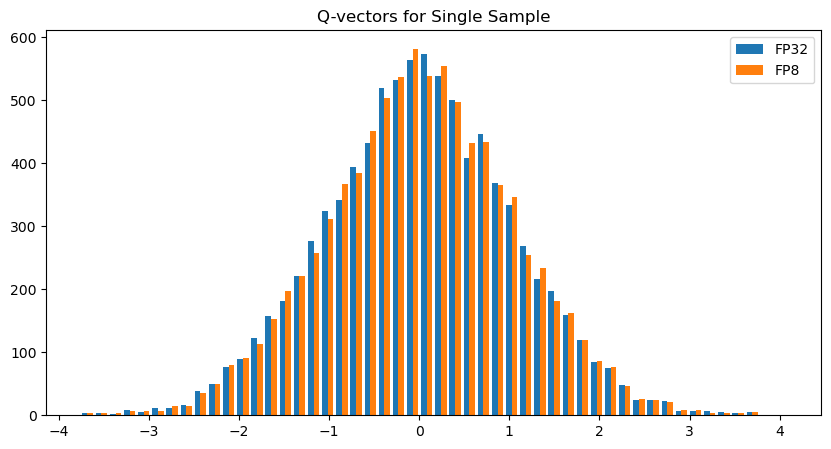

In [42]:
# Q-vectors
print(f'FP32: Mean = {qvector_fp32.mean():.6f}, Std = {qvector_fp32.std():.6f}')
print(f'FP8: Mean = {qvector_fp8.mean():.6f}, Std = {qvector_fp8.std():.6f}')

plt.figure(facecolor="w", figsize=(10, 5))
n_bins = 50

plt.title("Q-vectors for Single Sample")
plt.hist([qvector_fp32, qvector_fp8], n_bins, label=['FP32', 'FP8'])
plt.legend(loc='upper right')
plt.show()

FP32: Mean = -0.023228, Std = 1.016564
FP8: Mean = -0.024590, Std = 1.016063


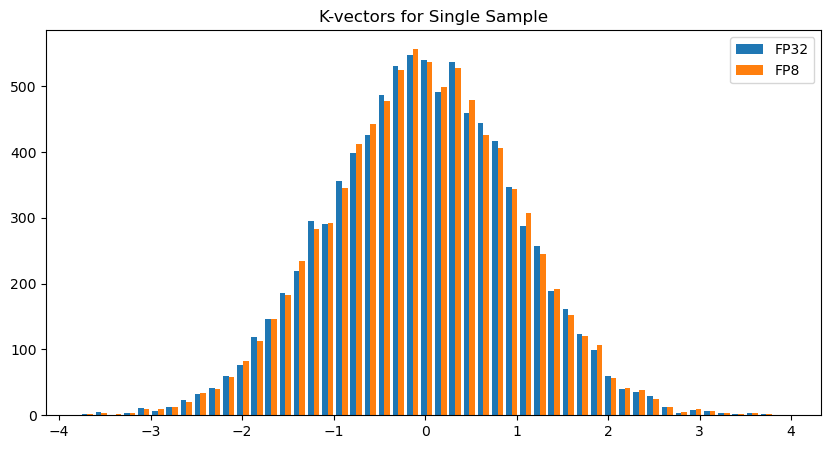

In [43]:
# K-vectors
print(f'FP32: Mean = {kvector_fp32.mean():.6f}, Std = {kvector_fp32.std():.6f}')
print(f'FP8: Mean = {kvector_fp8.mean():.6f}, Std = {kvector_fp8.std():.6f}')

plt.figure(facecolor="w", figsize=(10, 5))
n_bins = 50

plt.title("K-vectors for Single Sample")
plt.hist([kvector_fp32, kvector_fp8], n_bins, label=['FP32', 'FP8'])
plt.legend(loc='upper right')
plt.show()

### 2.1 Raw Scores 

In [45]:
# Vectors to numpy arrays
# Flatten the tensor
# Take it back to cpu, eliminate gradient, and turn into numpy array
rscore_fp32 = torch.flatten(raw_scores).cpu().detach().numpy()
rscore_fp8 = torch.flatten(raw_scores_fp8).cpu().detach().numpy()

FP32: Mean = 8.345048, Std = 12.196220
FP8: Mean = 8.228134, Std = 12.143971


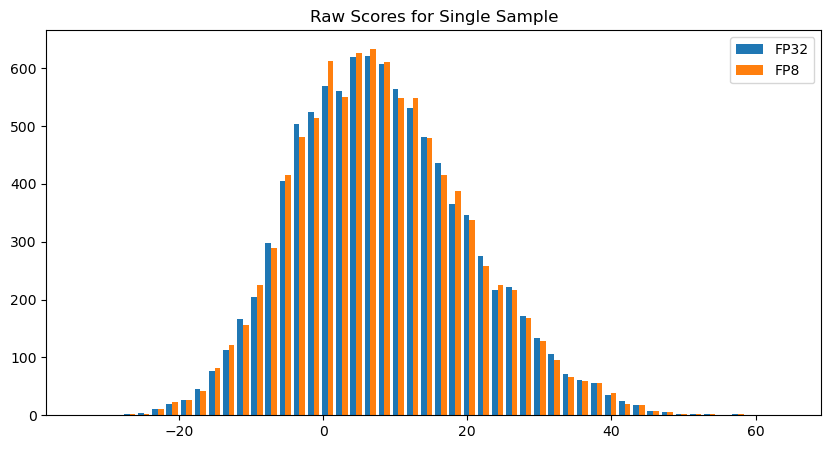

In [46]:
# Raw Scores
print(f'FP32: Mean = {rscore_fp32.mean():.6f}, Std = {rscore_fp32.std():.6f}')
print(f'FP8: Mean = {rscore_fp8.mean():.6f}, Std = {rscore_fp8.std():.6f}')

plt.figure(facecolor="w", figsize=(10, 5))
n_bins = 50

plt.title("Raw Scores for Single Sample")
plt.hist([rscore_fp32, rscore_fp8], n_bins, label=['FP32', 'FP8'])
plt.legend(loc='upper right')
plt.show()

### 3.1 Attention Scores 

In [47]:
# Vectors to numpy arrays
# Flatten the tensor
# Take it back to cpu, eliminate gradient, and turn into numpy array
attscore_fp32 = torch.flatten(attention_scores).cpu().detach().numpy()
attscore_fp8 = torch.flatten(attention_scores_fp8).cpu().detach().numpy()

FP32: Mean = 1.043131, Std = 1.524528
FP8: Mean = 1.028517, Std = 1.517996


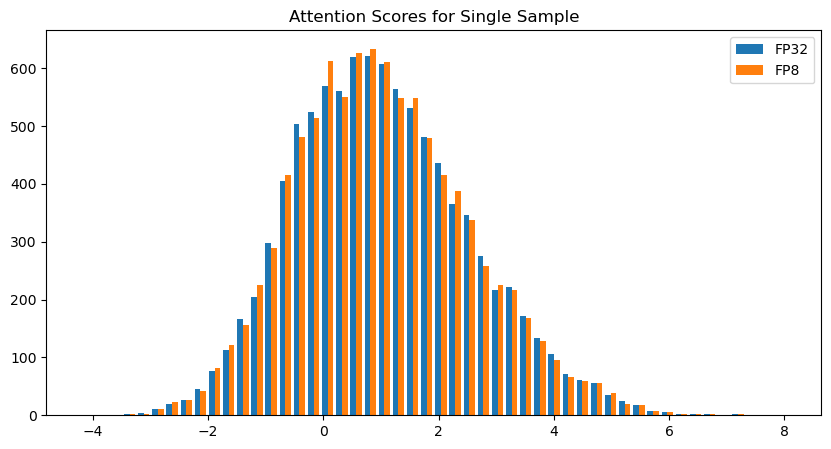

In [49]:
# Attention Scores
print(f'FP32: Mean = {attscore_fp32.mean():.6f}, Std = {attscore_fp32.std():.6f}')
print(f'FP8: Mean = {attscore_fp8.mean():.6f}, Std = {attscore_fp8.std():.6f}')

plt.figure(facecolor="w", figsize=(10, 5))
n_bins = 50

plt.title("Attention Scores for Single Sample")
plt.hist([attscore_fp32, attscore_fp8], n_bins, label=['FP32', 'FP8'])
plt.legend(loc='upper right')
plt.show()

### 3.1 Attention Probabilities

In [50]:
# Vectors to numpy arrays
# Flatten the tensor
# Take it back to cpu, eliminate gradient, and turn into numpy array
attprob_fp32 = torch.flatten(attention_probs).cpu().detach().numpy()
attprob_fp8 = torch.flatten(attention_probs_fp8).cpu().detach().numpy()

FP32: Mean = 0.014493, Std = 0.045385
FP8: Mean = 0.014493, Std = 0.045495


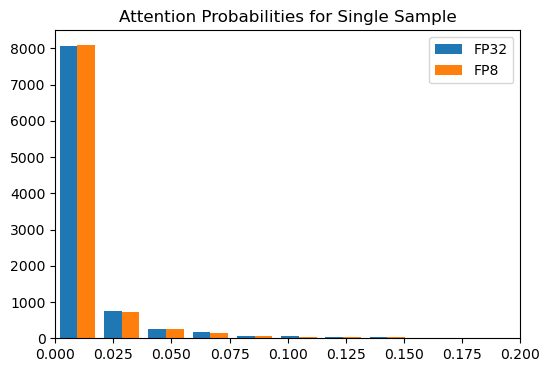

In [58]:
# Attention Probabilities
print(f'FP32: Mean = {attprob_fp32.mean():.6f}, Std = {attprob_fp32.std():.6f}')
print(f'FP8: Mean = {attprob_fp8.mean():.6f}, Std = {attprob_fp8.std():.6f}')

plt.figure(facecolor="w", figsize=(6, 4))
n_bins = 50

# Get the axis
ax = plt.gca()
ax.set_xlim([0, 0.2])
# ax.set_ylim([ymin, ymax])

plt.title("Attention Probabilities for Single Sample")
plt.hist([attprob_fp32, attprob_fp8], n_bins, label=['FP32', 'FP8'])
plt.legend(loc='upper right')
plt.show()

## 2. Whole Dataset
- Take 24 random samples from validation dataset

### 1.1 Q-vectors and K-vectors 

In [62]:
# Vectors to numpy arrays
# Flatten the tensor
# Take it back to cpu, eliminate gradient, and turn into numpy array
qvector_fp32_val = torch.flatten(q_vectors_val).cpu().detach().numpy()
print(qvector_fp32_val.shape)
qvector_fp8_val = torch.flatten(q_vectors_fp8_val).cpu().detach().numpy()
print(qvector_fp8_val.shape)

kvector_fp32_val = torch.flatten(k_vectors_val).cpu().detach().numpy()
print(kvector_fp32_val.shape)
kvector_fp8_val = torch.flatten(k_vectors_fp8_val).cpu().detach().numpy()
print(kvector_fp8_val.shape)

(1179648,)
(1179648,)
(1179648,)
(1179648,)


FP32: Mean = 0.026096, Std = 0.887899
FP8: Mean = 0.027543, Std = 0.888021


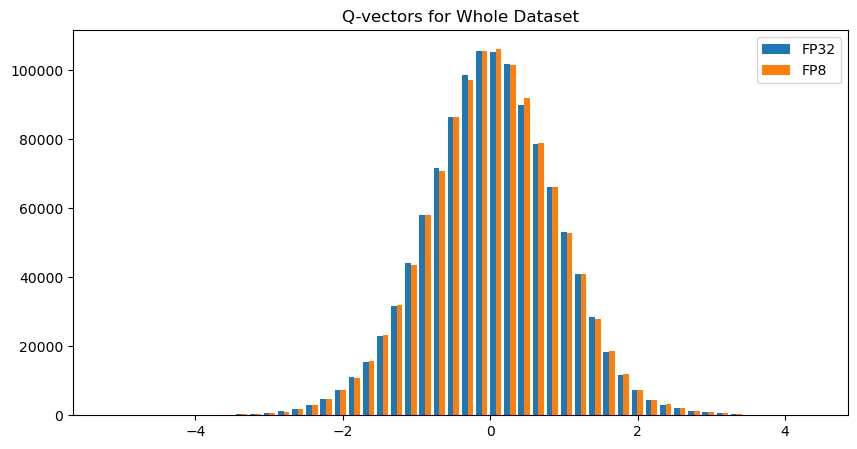

In [63]:
# Q-vectors
print(f'FP32: Mean = {qvector_fp32_val.mean():.6f}, Std = {qvector_fp32_val.std():.6f}')
print(f'FP8: Mean = {qvector_fp8_val.mean():.6f}, Std = {qvector_fp8_val.std():.6f}')

plt.figure(facecolor="w", figsize=(10, 5))
n_bins = 50

plt.title("Q-vectors for Whole Dataset")
plt.hist([qvector_fp32_val, qvector_fp8_val], n_bins, label=['FP32', 'FP8'])
plt.legend(loc='upper right')
plt.show()

FP32: Mean = -0.019406, Std = 0.900693
FP8: Mean = -0.018740, Std = 0.901276


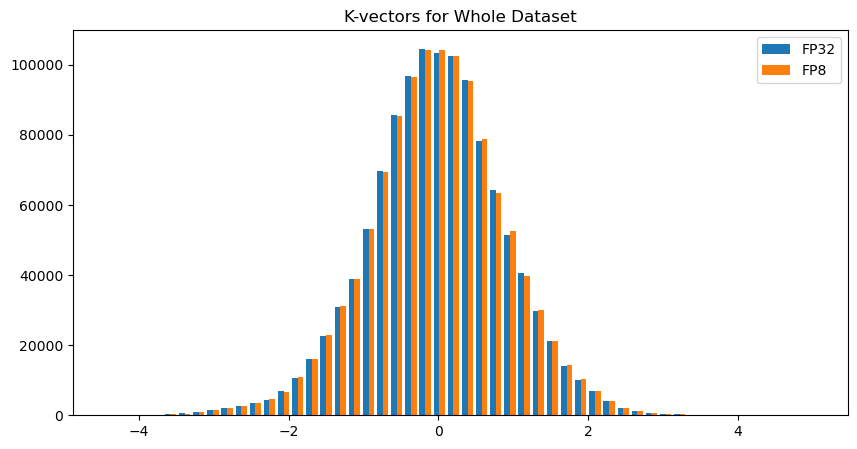

In [64]:
# K-vectors
print(f'FP32: Mean = {kvector_fp32_val.mean():.6f}, Std = {kvector_fp32_val.std():.6f}')
print(f'FP8: Mean = {kvector_fp8_val.mean():.6f}, Std = {kvector_fp8_val.std():.6f}')

plt.figure(facecolor="w", figsize=(10, 5))
n_bins = 50

plt.title("K-vectors for Whole Dataset")
plt.hist([kvector_fp32_val, kvector_fp8_val], n_bins, label=['FP32', 'FP8'])
plt.legend(loc='upper right')
plt.show()

### 2.1 Raw Scores 

In [65]:
# Vectors to numpy arrays
# Flatten the tensor
# Take it back to cpu, eliminate gradient, and turn into numpy array
rscore_fp32_val = torch.flatten(raw_scores_val).cpu().detach().numpy()
print(rscore_fp32_val.shape)
rscore_fp8_val = torch.flatten(raw_scores_fp8_val).cpu().detach().numpy()
print(rscore_fp8_val.shape)

(7077888,)
(7077888,)


FP32: Mean = -2.352339, Std = 9.982971
FP8: Mean = -2.417389, Std = 10.036436


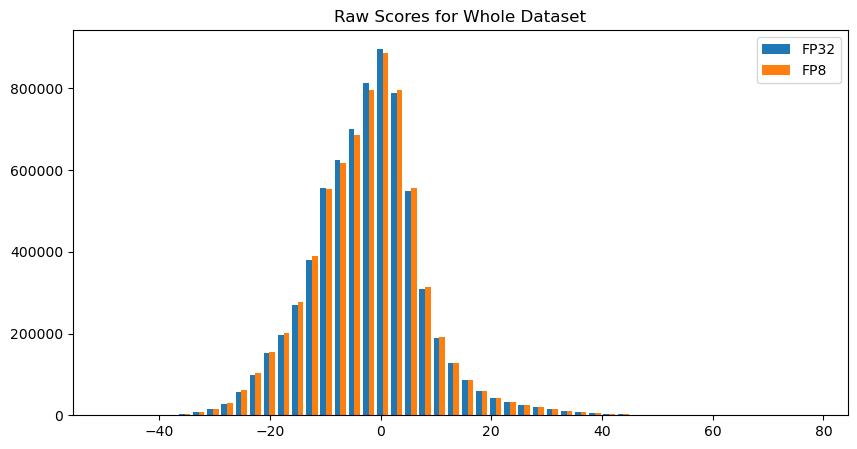

In [66]:
# Raw Scores
print(f'FP32: Mean = {rscore_fp32_val.mean():.6f}, Std = {rscore_fp32_val.std():.6f}')
print(f'FP8: Mean = {rscore_fp8_val.mean():.6f}, Std = {rscore_fp8_val.std():.6f}')

plt.figure(facecolor="w", figsize=(10, 5))
n_bins = 50

plt.title("Raw Scores for Whole Dataset")
plt.hist([rscore_fp32_val, rscore_fp8_val], n_bins, label=['FP32', 'FP8'])
plt.legend(loc='upper right')
plt.show()

### 3.1 Attention Scores 

In [67]:
# Vectors to numpy arrays
# Flatten the tensor
# Take it back to cpu, eliminate gradient, and turn into numpy array
attscore_fp32_val = torch.flatten(attention_scores_val).cpu().detach().numpy()
print(attscore_fp32_val.shape)
attscore_fp8_val = torch.flatten(attention_scores_fp8_val).cpu().detach().numpy()
print(attscore_fp8_val.shape)

(7077888,)
(7077888,)


FP32: Mean = -0.294042, Std = 1.247871
FP8: Mean = -0.302174, Std = 1.254555


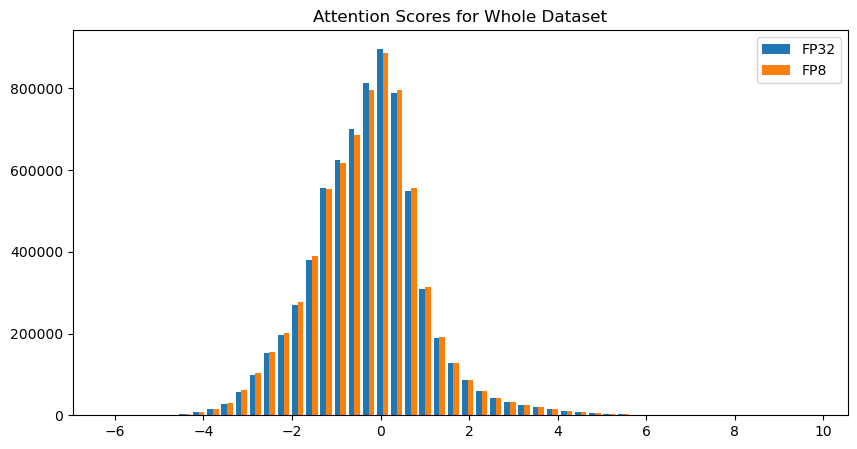

In [68]:
# Attention Scores
print(f'FP32: Mean = {attscore_fp32_val.mean():.6f}, Std = {attscore_fp32_val.std():.6f}')
print(f'FP8: Mean = {attscore_fp8_val.mean():.6f}, Std = {attscore_fp8_val.std():.6f}')

plt.figure(facecolor="w", figsize=(10, 5))
n_bins = 50

plt.title("Attention Scores for Whole Dataset")
plt.hist([attscore_fp32_val, attscore_fp8_val], n_bins, label=['FP32', 'FP8'])
plt.legend(loc='upper right')
plt.show()

### 3.1 Attention Probabilities

In [69]:
# Vectors to numpy arrays
# Flatten the tensor
# Take it back to cpu, eliminate gradient, and turn into numpy array
attprob_fp32_val = torch.flatten(attention_probs_val).cpu().detach().numpy()
print(attprob_fp32_val.shape)
attprob_fp8_val = torch.flatten(attention_probs_fp8_val).cpu().detach().numpy()
print(attprob_fp8_val.shape)

(7077888,)
(7077888,)


FP32: Mean = 0.002604, Std = 0.008719
FP8: Mean = 0.002604, Std = 0.008729


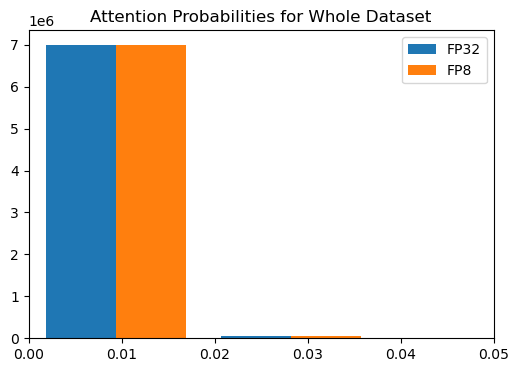

In [71]:
# Attention Probabilities
print(f'FP32: Mean = {attprob_fp32_val.mean():.6f}, Std = {attprob_fp32_val.std():.6f}')
print(f'FP8: Mean = {attprob_fp8_val.mean():.6f}, Std = {attprob_fp8_val.std():.6f}')

plt.figure(facecolor="w", figsize=(6, 4))
n_bins = 50

# Get the axis
ax = plt.gca()
ax.set_xlim([0, 0.05])
# ax.set_ylim([ymin, ymax])

plt.title("Attention Probabilities for Whole Dataset")
plt.hist([attprob_fp32_val, attprob_fp8_val], n_bins, label=['FP32', 'FP8'])
plt.legend(loc='upper right')
plt.show()

# Testing

- Transpose function

In [67]:
aux1 = torch.Tensor([[[1., 2., 3., 4.]]])
print(aux1)
print(aux1.shape)
print(aux1.size()[:-1])
print(aux1.size()[:-1] + (2,2))
print('\n')

aux1 = aux1.view(aux1.size()[:-1] + (2,2))
print(aux1)
print(aux1.shape)
print('\n')

aux1 = aux1.permute(0, 2, 1, 3)
print(aux1)
print(aux1.shape)

tensor([[[1., 2., 3., 4.]]])
torch.Size([1, 1, 4])
torch.Size([1, 1])
torch.Size([1, 1, 2, 2])


tensor([[[[1., 2.],
          [3., 4.]]]])
torch.Size([1, 1, 2, 2])


tensor([[[[1., 2.]],

         [[3., 4.]]]])
torch.Size([1, 2, 1, 2])
